# Importations

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Données
## application_train_test

### <span style='color:purple'> *application_train_test* </span>

In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    

    # Categorical features with Binary encode (0 or 1; two categories)
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                df[col], uniques = pd.factorize(df[col])
            
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [6]:
df = pd.read_csv('application_train.csv', nrows= None)


### Target

In [7]:
df_bar = pd.DataFrame()
df_bar['TARGET'] = df['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df[df['TARGET']==x]))
df_bar

TARGET   count
0       1   24825
1       0  282686

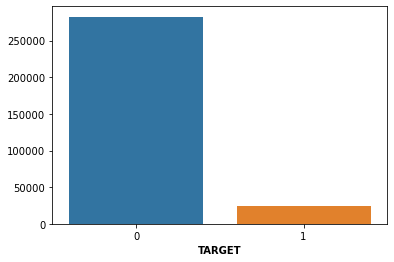

In [8]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [9]:
len(df.loc[df['TARGET']==1])/len(df)*100

8.072881945686495

In [10]:
float_columns = [col for col in df.columns if df[col].dtype == 'float']
int_column = [col for col in df.columns if df[col].dtype == 'int']

### <span style='color:purple'> *visualisation_float_col* </span>

In [11]:
def visualisation_float_col(df, list_col, nb_col, size=7):
    df_violin = df.copy()
    df_violin["all"] = ""
    nb = len(list_col)
    if nb%nb_col!=0:
        fig, ax = plt.subplots(nb//nb_col+1, nb_col, figsize=(nb_col*size, (nb//nb_col+1)*5)) 
    else:
        fig, ax = plt.subplots(nb//nb_col, nb_col, figsize=(nb_col*size, (nb//nb_col)*5)) 
    for i, col in enumerate(list_col):
        if nb<=nb_col:
            if nb>1:
                sns.violinplot(ax=ax[i], data=df_violin, x="all", y=col , hue="TARGET", split=True)
                ax[i].set_xlabel(col, weight='bold')
                ax[i].set_ylabel('')
            else:
                sns.violinplot(ax=ax, data=df_violin, x="all", y=col , hue="TARGET", split=True)
                ax.set_xlabel(col, weight='bold')
                ax.set_ylabel('')                
        else:
            if nb_col>1:
                sns.violinplot(ax=ax[i//nb_col][i%nb_col], data=df_violin, x="all", y=col , hue="TARGET", split=True)
                ax[i//nb_col][i%nb_col].set_xlabel(col, weight='bold')
                ax[i//nb_col][i%nb_col].set_ylabel('')  
                
            else:
                sns.violinplot(ax=ax[i], data=df_violin,x="all", y=col , hue="TARGET", split=True)
                ax[i].set_xlabel(col, weight='bold')
                ax[i].set_ylabel('')

### <span style='color:purple'> *visualisation_float_col2* </span>

In [12]:
def visualisation_float_col2(df, list_col, nb_col, size=7):
    df_violin = df.copy()
    df_violin["all"] = ""
    nb = len(list_col)
    if nb%nb_col!=0:
        fig, ax = plt.subplots(nb//nb_col+1, nb_col, figsize=(nb_col*size, (nb//nb_col+1)*5)) 
    else:
        fig, ax = plt.subplots(nb//nb_col, nb_col, figsize=(nb_col*size, (nb//nb_col)*5)) 
    for i, col in enumerate(list_col):
        if nb<=nb_col:
            if nb>1:
                sns.violinplot(ax=ax[i], data=df_violin, x="all", y=(df_violin[col])**(1/15) , hue="TARGET", split=True)
                ax[i].set_xlabel(col, weight='bold')
                ax[i].set_ylabel('')
            else:
                sns.violinplot(ax=ax, data=df_violin, x="all", y=(df_violin[col])**(1/15) , hue="TARGET", split=True)
                ax.set_xlabel(col, weight='bold')
                ax.set_ylabel('')                
        else:
            if nb_col>1:
                sns.violinplot(ax=ax[i//nb_col][i%nb_col], data=df_violin, x="all", y=(df_violin[col])**(1/15) , hue="TARGET", split=True)
                ax[i//nb_col][i%nb_col].set_xlabel(col, weight='bold')
                ax[i//nb_col][i%nb_col].set_ylabel('')  
                
            else:
                sns.violinplot(ax=ax[i], data=df_violin,x="all", y=(df_violin[col])**(1/15) , hue="TARGET", split=True)
                ax[i].set_xlabel(col, weight='bold')
                ax[i].set_ylabel('')

### <span style='color:purple'> *visualisation_categories* </span>

In [13]:
def visualisation_categories(df, list_cat, nb_col, size=7, rotate=False):
    nb = len(list_cat)
    if nb%nb_col!=0:
        fig, ax = plt.subplots(nb//nb_col+1, nb_col, figsize=(nb_col*size, (nb//nb_col+1)*7)) 
    else:
        fig, ax = plt.subplots(nb//nb_col, nb_col, figsize=(nb_col*size, (nb//nb_col)*7)) 
    for i, cat in enumerate(list_cat):
        df_visu1 = pd.DataFrame()
        df_visu1[cat] = df.loc[df['TARGET']==1][cat].dropna().unique()
        df_visu1['count'] = df_visu1[cat]
        df1 = pd.DataFrame(df.loc[df['TARGET']==1][cat].value_counts()).reset_index()
        df_visu1['count'] = df_visu1['count'].apply(lambda x: (df1.loc[df1['index']==x][cat].values[0])*coef1)
        df_visu1['TARGET'] = 1  
        df_visu0 = pd.DataFrame()
        df_visu0[cat] = df.loc[df['TARGET']==0][cat].dropna().unique()
        df_visu0['count'] = df_visu0[cat]
        df0 = pd.DataFrame(df.loc[df['TARGET']==0][cat].value_counts()).reset_index()
        df_visu0['count'] = df_visu0['count'].apply(lambda x: (df0.loc[df0['index']==x][cat].values[0])*coef0)
        df_visu0['TARGET'] = 0
        df_tot = df_visu0.append(df_visu1).reset_index()
        if nb<=nb_col:
            if nb>1:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax, data=df_tot, x=cat, y='count', hue='TARGET')
                ax.set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')                
        else:
            if nb_col>1:
                sns.barplot(ax=ax[i//nb_col][i%nb_col], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i//nb_col][i%nb_col].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i//nb_col][i%nb_col].set_xticklabels(ax[i//nb_col][i%nb_col].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
            

### <span style='color:purple'> *visualisation_categories2* </span>

In [14]:
def visualisation_categories2(df, list_cat, nb_col, size=7, rotate=False):
    nb = len(list_cat)
    if nb%nb_col!=0:
        fig, ax = plt.subplots(nb//nb_col+1, nb_col, figsize=(nb_col*size, (nb//nb_col+1)*7)) 
    else:
        fig, ax = plt.subplots(nb//nb_col, nb_col, figsize=(nb_col*size, (nb//nb_col)*7)) 
    for i, cat in enumerate(list_cat):
        df_visu1 = pd.DataFrame()
        df_visu1[cat] = df.loc[df['TARGET']==1][cat].dropna().unique()
        df_visu1['count'] = df_visu1[cat]
        df1 = pd.DataFrame(df.loc[df['TARGET']==1][cat].value_counts()).reset_index()
        df_visu1['count'] = df_visu1['count'].apply(lambda x: ((df1.loc[df1['index']==x][cat].values[0])*coef1)**(1/8))
        df_visu1['TARGET'] = 1  
        df_visu0 = pd.DataFrame()
        df_visu0[cat] = df.loc[df['TARGET']==0][cat].dropna().unique()
        df_visu0['count'] = df_visu0[cat]
        df0 = pd.DataFrame(df.loc[df['TARGET']==0][cat].value_counts()).reset_index()
        df_visu0['count'] = df_visu0['count'].apply(lambda x: ((df0.loc[df0['index']==x][cat].values[0])*coef0)**(1/8))
        df_visu0['TARGET'] = 0
        df_tot = df_visu0.append(df_visu1).reset_index()
        if nb<=nb_col:
            if nb>1:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax, data=df_tot, x=cat, y='count', hue='TARGET')
                if rotate==True:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')                
        else:
            if nb_col>1:
                sns.barplot(ax=ax[i//nb_col][i%nb_col], data=df_tot, x=cat, y='count', hue='TARGET')
                if rotate==True:
                    ax[i//nb_col][i%nb_col].set_xticklabels(ax[i//nb_col][i%nb_col].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

In [15]:
def visualisation_categories_coef(df, list_cat, nb_col, coef0, coef1, size=7, rotate=False):
    nb = len(list_cat)
    if nb%nb_col!=0:
        fig, ax = plt.subplots(nb//nb_col+1, nb_col, figsize=(nb_col*size, (nb//nb_col+1)*5)) 
    else:
        fig, ax = plt.subplots(nb//nb_col, nb_col, figsize=(nb_col*size, (nb//nb_col)*5)) 
    for i, cat in enumerate(list_cat):
        df_visu1 = pd.DataFrame()
        df_visu1[cat] = df.loc[df['TARGET']==1][cat].dropna().unique()
        df_visu1['count'] = df_visu1[cat]
        df1 = pd.DataFrame(df.loc[df['TARGET']==1][cat].value_counts()).reset_index()
        df_visu1['count'] = df_visu1['count'].apply(lambda x: (df1.loc[df1['index']==x][cat].values[0])*coef1)
        df_visu1['TARGET'] = 1  
        df_visu0 = pd.DataFrame()
        df_visu0[cat] = df.loc[df['TARGET']==0][cat].dropna().unique()
        df_visu0['count'] = df_visu0[cat]
        df0 = pd.DataFrame(df.loc[df['TARGET']==0][cat].value_counts()).reset_index()
        df_visu0['count'] = df_visu0['count'].apply(lambda x: (df0.loc[df0['index']==x][cat].values[0])*coef0)
        df_visu0['TARGET'] = 0
        df_tot = df_visu0.append(df_visu1).reset_index()
        if nb<=nb_col:
            if nb>1:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax, data=df_tot, x=cat, y='count', hue='TARGET')
                ax.set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')                
        else:
            if nb_col>1:
                sns.barplot(ax=ax[i//nb_col][i%nb_col], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i//nb_col][i%nb_col].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i//nb_col][i%nb_col].set_xticklabels(ax[i//nb_col][i%nb_col].get_xticklabels(), rotation=45, ha='right')
            else:
                sns.barplot(ax=ax[i], data=df_tot, x=cat, y='count', hue='TARGET')
                ax[i].set_xlabel(cat, weight='bold')
                if rotate==True:
                    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

In [16]:
train_set = application_train_test(num_rows = None, nan_as_category = False)

Train samples: 307511, test samples: 48744


### <span style='color:purple'> *supp_empty_features* </span>

In [17]:
def supp_empty_features(df, percent_mini=50, features_excluded=[]):
    """
    Remove feature if NaN value percentage of feature > than percent_mini and feature not in features_excluded
    """
    perc_null_values_per_feature = df.isna().sum()/len(df)*100
    mask = perc_null_values_per_feature<=percent_mini
    full_features =  list(perc_null_values_per_feature[mask].index)
    features_kept = full_features + features_excluded
    df_without_empty_features = df.loc[:,features_kept]
    return df_without_empty_features

### <span style='color:purple'> *imputer_df* </span>

In [18]:
from sklearn.impute import SimpleImputer, KNNImputer
def imputer_df(df, n_neighbors=5, columns_KNNImputer=[], columns_mean=[], columns_median=[], columns_most_frequent=[], column_constant=[]):

    """
    imputer for a dataframe df
    
    Arguments:
    ---------------------------
    df : dataframe to imput,
    n_neighbors : number of neighbors for KNNImputer,
    columns_KNNImputer : [columns to impute with KNNImputer],
    columns_mean: [columns to impute with mean of values],
    columns_median: [columns to impute with median of values],
    columns_most_frequent: [columns to impute with most_frequent of values],
    column_constant: list of tuple (constant, column_constant to fill in with constant)
     
    Return:
    ---------------------------
    df : df completed
    """
    df1 = df.copy()
    if columns_KNNImputer!=[]:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df1.loc[:, columns_KNNImputer] = imputer.fit_transform(df1.loc[:, columns_KNNImputer])
    if columns_mean!=[]:
        imputer = SimpleImputer(strategy='mean')
        df1.loc[:, columns_mean] = imputer.fit_transform(df1.loc[:, columns_mean])
    if columns_median!=[]:
        imputer = SimpleImputer(strategy='median')
        df1.loc[:, columns_median] = imputer.fit_transform(df1.loc[:, columns_median])
    if columns_most_frequent!=[]:
        imputer = SimpleImputer(strategy='most_frequent')
        df1.loc[:, columns_most_frequent] = imputer.fit_transform(df1.loc[:, columns_most_frequent])
    if column_constant!=[]:    
        for (const, col) in [(constant, column_constant)]:
            imputer = SimpleImputer(strategy='constant', fill_value=const)
            df1.loc[:, col] = imputer.fit_transform(df1.loc[:, col])
    return df1    

In [19]:
#df2 = imputer_df(df, columns_KNNImputer=['EXT_SOURCE_1', 'EXT_SOURCE_3'], columns_mean=['EXT_SOURCE_2'])

In [20]:
#df2['EXT_SOURCE_1']

## bureau 

In [21]:
bureau = pd.read_csv('bureau.csv', nrows = None)
bureau.head(1)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN

## Bureau_balance

In [22]:
bb = pd.read_csv('bureau_balance.csv', nrows = None)
bb.head(1)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C

## Bureau agg
#### <span style='color:purple'> *bureau_and_balance* </span>

In [23]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Replace bureau['DAYS_CREDIT_ENDDATE'] by (-2920) if bureau['DAYS_CREDIT_ENDDATE']<-2920
    bureau[bureau['DAYS_CREDIT_ENDDATE']<-2920]=-2920
    bureau[bureau['DAYS_ENDDATE_FACT']<-2920]=-2920
         
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)

    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Optionnal: Remove 1 customer with BURO_DAYS_CREDIT_UPDATE_MEAN>0
    bureau_agg = bureau_agg.loc[bureau_agg['BURO_DAYS_CREDIT_UPDATE_MEAN']<=0]

    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [24]:
bureau_agg = bureau_and_balance(num_rows = None, nan_as_category = True)
bureau_agg.describe()

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
count         305808.000000         305808.000000          305808.000000   
mean           -1764.191189           -490.952245           -1083.726846   
std              859.238393            533.544569             558.437275   
min            -2922.000000          -2922.000000           -2922.000000   
25%            -2583.000000           -623.000000           -1430.921875   
50%            -1822.000000           -305.000000           -1052.387500   
75%            -1045.000000           -149.000000            -670.333333   
max                0.000000              0.000000               0.000000   

       BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
count          2.642800e+05                 303223.000000   
mean           4.854650e+05                  -1013.529191   
std            4.625430e+05                   2493.696411   
min            0.000000e+00                  -2920.000000   
25%            1.256868e+05                  -2127.000000   
50%            3.803061e+05                  -1271.000000   
75%            7.128844e+05                   -458.000000   
max            4.173160e+06                  31198.000000   

       BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
count                 303223.000000                  303223.000000   
mean                    4509.085274                     665.931262   
std                     9421.644008                    3274.517098   
min                    -2920.000000                   -2920.000000   
25%                      126.000000                    -696.881944   
50%                      912.000000                    -131.000000   
75%                     1692.000000                     613.472222   
max                    31199.000000                   31198.000000   

       BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
count                 305808.000000                305808.000000   
mean                    -542.986033                     4.422399   
std                      446.485417                    85.697674   
min                   -41890.000000                 -2920.000000   
25%                     -773.703571                     0.000000   
50%                     -479.297059                     0.000000   
75%                     -209.000000                     0.000000   
max                        0.000000                  2792.000000   

       BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
count                 305808.000000                      2.129510e+05   
mean                       0.954113                      5.005417e+03   
std                       25.477363                      2.856953e+05   
min                    -2920.000000                     -2.920000e+03   
25%                        0.000000                      0.000000e+00   
50%                        0.000000                      0.000000e+00   
75%                        0.000000                      2.063903e+03   
max                     2776.000000                      1.159872e+08   

       BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  \
count             3.058060e+05              3.058060e+05   
mean              9.917488e+05              3.807465e+05   
std               2.317448e+06              8.792761e+05   
min              -2.920000e+03             -2.920000e+03   
25%               1.800000e+05              1.039633e+05   
50%               4.500000e+05              1.973085e+05   
75%               1.079100e+06              3.979023e+05   
max               5.850000e+08              1.980723e+08   

       BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  \
count             3.058080e+05                  2.974350e+05   
mean              1.992432e+06                  5.300301e+05   
std               4.165812e+06                  1.357631e+06   
min              -4.467600e+05                 -2.595965e+04   
25%      

## Previous_applications

In [25]:
# SK_ID_PREV : ID of previous credit in Home credit related to loan in our sample. 

In [26]:
prev = pd.read_csv('previous_application.csv', nrows = None)

#### <span style='color:purple'> *previous_applications* </span>

In [27]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev.loc[prev['APP_CREDIT_PERC']>1e100, 'APP_CREDIT_PERC'] = np.NaN
    
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

## POS_CASH_balance

In [28]:
pos = pd.read_csv('POS_CASH_balance.csv', nrows = None)
pos.head(1)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0

#### <span style='color:purple'> *pos_cash* </span>

In [29]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [30]:
pos_cash_result = pos_cash(num_rows=None)
pos_cash_result.head(1)

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   

            POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
SK_ID_CURR                                           
100001                                         0.0   

            POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
SK_ID_CURR                                            
100001                                     0.222222   

            POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     

            POS_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                         
100001                                       0.0   

            POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
SK_ID_CURR                                      
100001                                    0.0   

            POS_NAME_CONTRACT_STATUS_nan_MEAN  POS_COUNT  
SK_ID_CURR                                                
100001                                    0.0          9

## installments_payments
#### <span style='color:purple'> *installments_payments* </span>

In [31]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins.loc[ins['PAYMENT_PERC']>1e100, 'PAYMENT_PERC'] = np.NaN
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

## credit_card_balance

In [32]:
cc = pd.read_csv('credit_card_balance.csv', nrows = None)
cc.head(1)

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6        56.97   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                       0.0            0.0                   0.0   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0

#### <span style='color:purple'> *credit_card_balance* </span>

In [33]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    # Suppress customer if cc['AMT_DRAWINGS_ATM_CURRENT']<0 or cc['AMT_DRAWINGS_CURRENT']<0
    mask = cc['AMT_DRAWINGS_ATM_CURRENT']<0
    cc = cc[~mask]
    mask = cc['AMT_DRAWINGS_CURRENT']<0
    cc = cc[~mask]
    
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    
    
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [34]:
cc_result = credit_card_balance()

## Préparation des datas

### Missing datas

In [35]:
def process_missing_data_median(df, perc, features_excluded=[]):
    df_full = supp_empty_features(df, percent_mini=perc, features_excluded=[])
    columns_all = [col for col in list(df_full.columns) if col not in ['index','SK_ID_CURR','TARGET']]
    perc_null_values_per_feature = df_full.isna().sum()/len(df_full)*100
    perc_null_values_per_feature = list(perc_null_values_per_feature[perc_null_values_per_feature>0].index)
    columns_empty = [col for col in columns_all if col in perc_null_values_per_feature]
    columns_full = [col for col in columns_all if col not in perc_null_values_per_feature]
    data_fullfilled = imputer_df(df_full, n_neighbors=5, columns_KNNImputer=[], columns_mean=[], columns_median=columns_empty, columns_most_frequent=[], column_constant=[])
    return data_fullfilled

In [42]:
df_filtered = df.notna()

### Fonctions preprocess

In [54]:
def phase1(debug = True, num_rows=10000):
    num_rows = num_rows if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print(f"data avant remplissage shape : {df.shape}")
    with timer("Process missing data"):
        df = process_missing_data_median(df, perc=80, features_excluded=[])
        print(f"data final shape : {df.shape}")
    return df

In [55]:
def phase1_with_nan(debug = True, num_rows=10000):
    num_rows = num_rows if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    mapping = [ (',', '_'), ('[', '_'), (']', '_'), ('{', '_'), ('}', '_'), (':', '_'), ('"', '_'), (" ", '_')]
    for col in df.columns:
        col_modif = col
        for k, v in mapping:
            col_modif= col_modif.replace(k, v)
        df = df.rename(columns={col: col_modif})
    print(f"data avant remplissage shape : {df.shape}")
    print(f"data final shape : {df.shape}")
    return df

### Imbalanced data

In [43]:
df_bar = pd.DataFrame()
df_full = phase1()
df_full = df_full.loc[df_full['TARGET'].notna()]
df_bar['TARGET'] = df_full['TARGET'].unique()
df_bar['count'] = df_bar['TARGET']
df_bar['count'] = df_bar['count'].apply(lambda x: len(df_full[df_full['TARGET']==x]))
df_bar

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (20000, 767)
data final shape : (20000, 245)
Process missing data - done in 1s


TARGET  count
0     1.0    775
1     0.0   9225

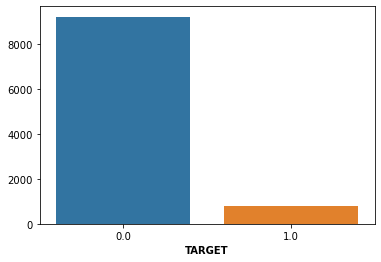

In [44]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, data=df_bar, x='TARGET', y='count')
ax.set_xlabel('TARGET', weight='bold')
ax.set_ylabel('');

In [45]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)

In [48]:
X_train_over, y_train_over = over.fit_resample(df_full.drop('TARGET', axis=1), df_full['TARGET'])
X_train_under, y_train_under = under.fit_resample(X_train_over, y_train_over)
x_over = ((y_train_over).value_counts()).to_frame()
x_under = (y_train_under.value_counts()).to_frame()

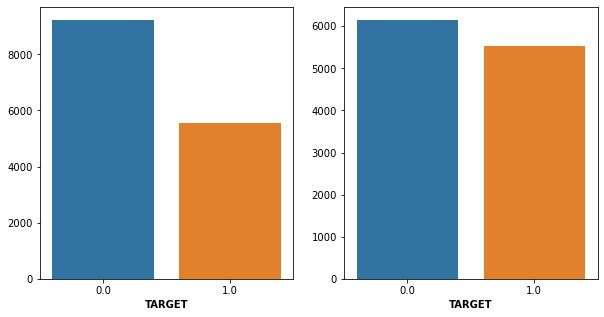

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(ax=ax[0], data=x_over, x=x_over.index, y='TARGET')
sns.barplot(ax=ax[1], data=x_under, x=x_under.index, y='TARGET')
ax[0].set_xlabel('TARGET', weight='bold')
ax[0].set_ylabel('')
ax[1].set_xlabel('TARGET', weight='bold')
ax[1].set_ylabel('');

### Datas préparées

In [50]:
data_transformed = phase1(debug = True)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (20000, 767)
data final shape : (20000, 245)
Process missing data - done in 1s


In [51]:
data_transformed_1000 = phase1(debug = True, num_rows=1000)

Train samples: 1000, test samples: 1000
Bureau df shape: (205, 99)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (985, 221)
Process previous_applications - done in 0s
Pos-cash balance df shape: (989, 12)
Process POS-CASH balance - done in 0s
Installments payments df shape: (965, 26)
Process installments payments - done in 1s
Credit card balance df shape: (1000, 116)
Process credit card balance - done in 1s
data avant remplissage shape : (2000, 708)
data final shape : (2000, 234)
Process missing data - done in 0s


In [52]:
data_transformed_20000 = phase1(debug = True, num_rows=20000)

Train samples: 20000, test samples: 20000
Bureau df shape: (3990, 109)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (19006, 245)
Process previous_applications - done in 2s
Pos-cash balance df shape: (18534, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (16356, 26)
Process installments payments - done in 1s
Credit card balance df shape: (17659, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (40000, 771)
data final shape : (40000, 245)
Process missing data - done in 1s


In [56]:
data_transformed_unfilled = phase1_with_nan(debug = True)

Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 0s
Installments payments df shape: (8893, 26)
Process installments payments - done in 1s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
data avant remplissage shape : (20000, 767)
data final shape : (20000, 767)


In [57]:
data_transformed_unfilled_1000 = phase1_with_nan(debug = True, num_rows=1000)

Train samples: 1000, test samples: 1000
Bureau df shape: (205, 99)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (985, 221)
Process previous_applications - done in 1s
Pos-cash balance df shape: (989, 12)
Process POS-CASH balance - done in 0s
Installments payments df shape: (965, 26)
Process installments payments - done in 0s
Credit card balance df shape: (1000, 116)
Process credit card balance - done in 0s
data avant remplissage shape : (2000, 708)
data final shape : (2000, 708)


In [58]:
data_transformed_100000 = phase1(debug = True, num_rows=100000)

Train samples: 100000, test samples: 48744
Bureau df shape: (23122, 113)
Process bureau and bureau_balance - done in 2s
Previous applications df shape: (79977, 247)
Process previous_applications - done in 4s
Pos-cash balance df shape: (77469, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (48591, 26)
Process installments payments - done in 1s
Credit card balance df shape: (53383, 131)
Process credit card balance - done in 2s
data avant remplissage shape : (148741, 779)
data final shape : (148741, 456)
Process missing data - done in 25s


# Base line : Logistic regression

In [97]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import shap
import random

## Functions
### display_importances

In [75]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    best_features = best_features[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values('importance', ascending=False), color='blue', saturation=0.2)
    plt.title('Features Importance(avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

### score_function

In [76]:
def score_function(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    return len(y)/(10*cm[1][0] + cm[0][1])
from sklearn.metrics import make_scorer
custom_score = make_scorer(score_function, greater_is_better=True, needs_proba=False)

### score_df

In [764]:
def score_df(results_train, results_valid, results_test):
    df = pd.DataFrame(columns = ['Validation', 'Train', 'Test'], index = ['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    df['Train'] = results_train
    df['Validation'] = results_valid
    df['Test'] = results_test
    return(df)

## roc_auc - Threshold decision function moved

In [732]:
import pickle

def Log_reg(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train.to_csv('X_train.csv')
    X_test.to_csv('X_test.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')
    
   
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame(index=['Accuracy', 'Cost', 'F1_score', 'Precision', 'Profit', 'Recall', 'roc_auc'])
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01) 
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.01, 0.2, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = result_validation_set.mean(axis=1)
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01) 
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_model.pk'
    pickle.dump(pipe, open(filename, 'wb'))

    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df)
  


In [892]:
def model1_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression"):
        Log_reg(df, num_folds=10, stratified = True)

Threshold optimum: 0.08
Threshold optimum: 0.09
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.11
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.08
Threshold optimum: 0.12
Threshold optimum - Mean: 0.096
           Validation      Train       Test
Accuracy     0.885000   0.775000   0.762000
Cost        57.625000  53.775000  54.850000
F1_score     0.313433   0.275362   0.265432
Precision    0.291667   0.183476   0.174442
Profit      34.625000  38.475000  37.400000
Recall       0.338710   0.551613   0.554839
roc_auc      0.659542   0.742870   0.751213
Run Logistic regression - done in 6s


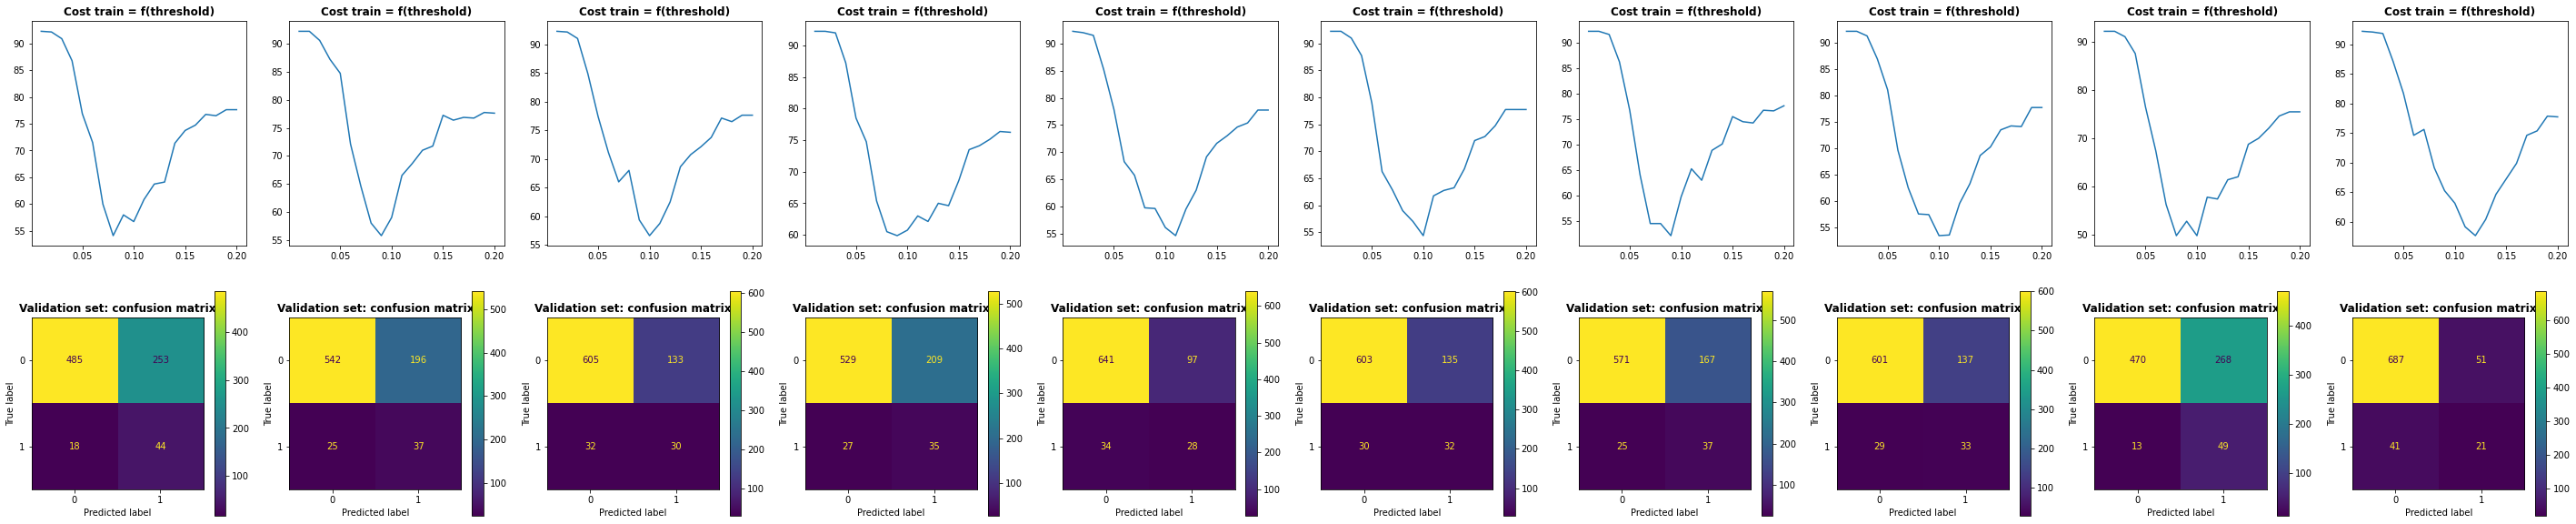

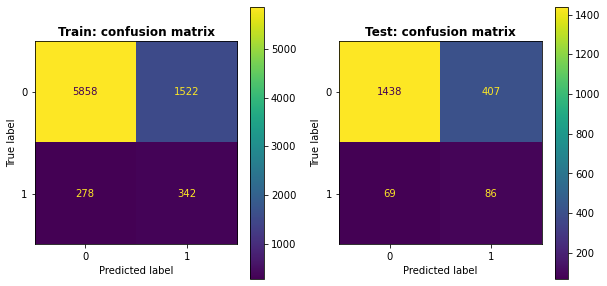

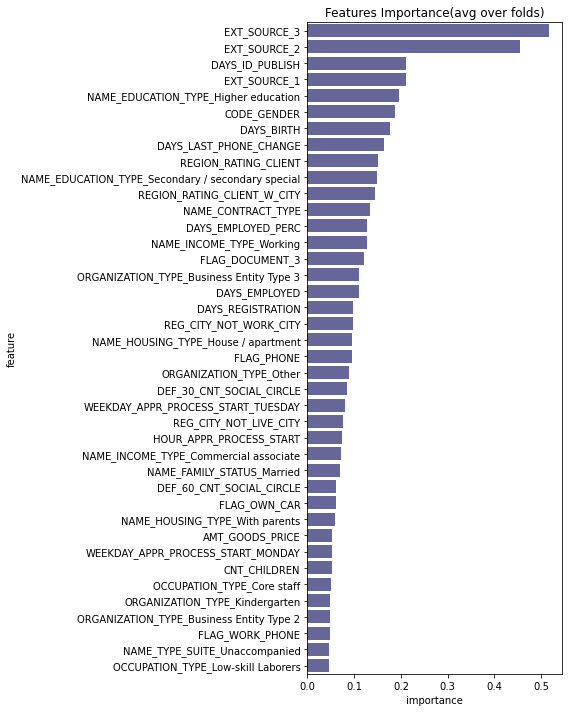

In [893]:
model1_Log_reg(data_transformed)

In [738]:
saved_Log_reg_model = pickle.load(open('Log_reg_model.pk', 'rb'))
saved_Log_reg_model

Pipeline(steps=[('scl', MinMaxScaler()),
                ('model', LogisticRegression(C=0.01, max_iter=2000))])

In [739]:
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('X_test.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('y_train.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('y_test.csv').drop('Unnamed: 0', axis=1)
pd.Series(y_train['TARGET'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7995    0.0
7996    0.0
7997    0.0
7998    1.0
7999    0.0
Name: TARGET, Length: 8000, dtype: float64

In [740]:
class WaterfallData():
    def __init__ (self, shap_test, col, expected_value, data):
        self.values = shap_test[col].values
        self.base_values = expected_value
        self.data = data
        self.feature_names = shap_test.index
        self.display_data = shap_test.index

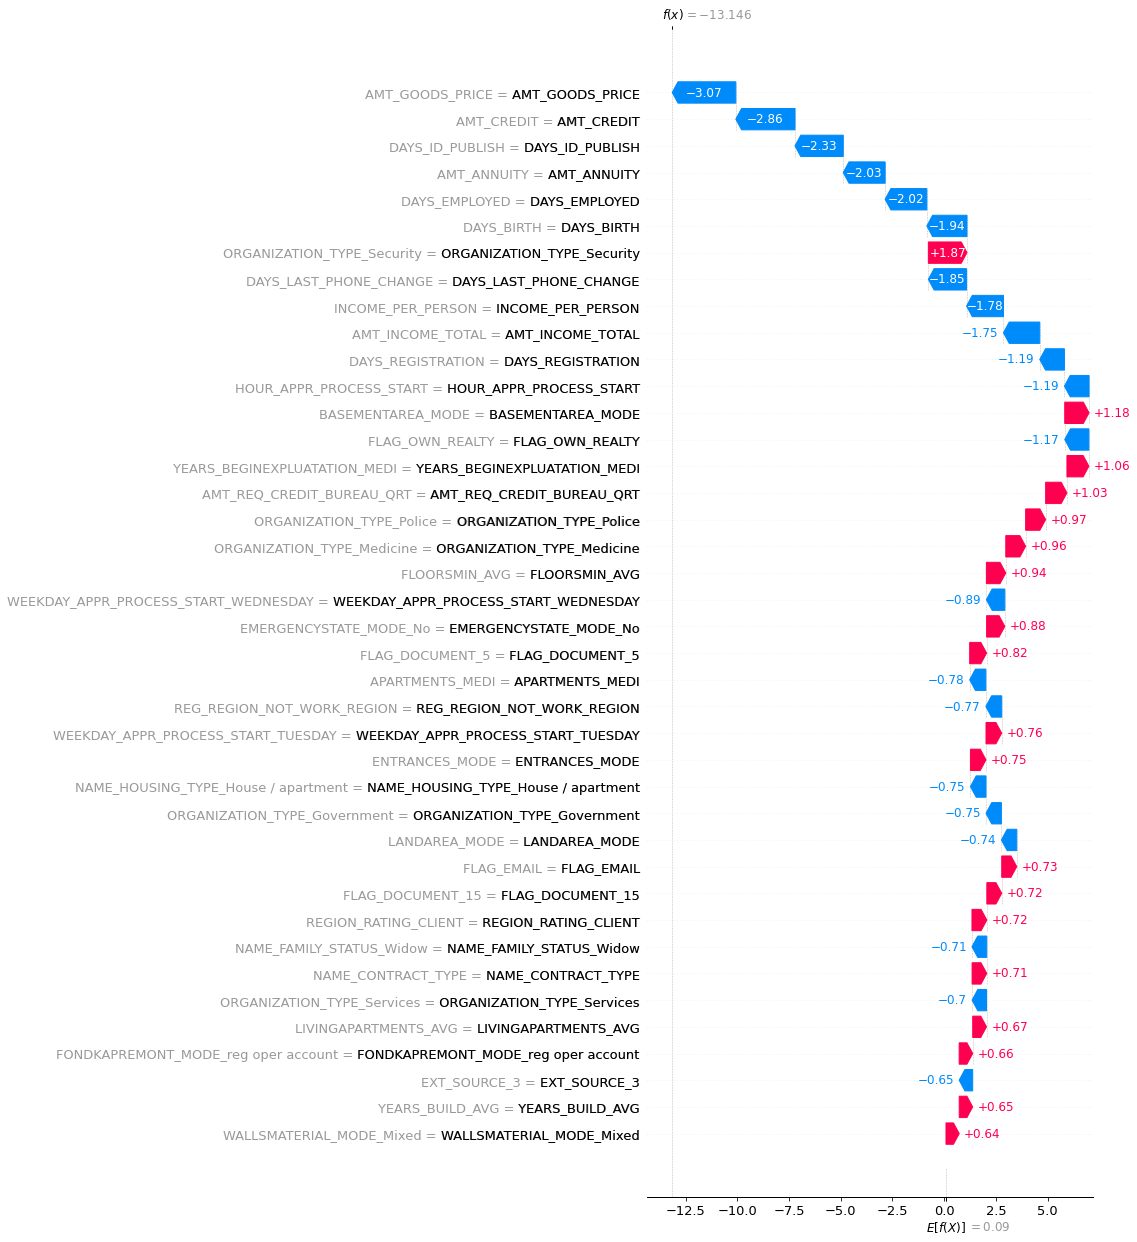

In [741]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Log_reg_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09999999999999999
Threshold optimum: 0.09
Threshold optimum: 0.09
Threshold optimum: 0.09
Threshold optimum - Mean: 0.094
           Validation      Train       Test
Accuracy     0.700169   0.726340   0.726950
Cost        56.422276  54.952061  54.710000
F1_score     0.255933   0.268707   0.270017
Precision    0.160132   0.171426   0.172296
Profit      35.483468  36.955136  37.195000
Recall       0.637066   0.621254   0.623842
roc_auc      0.735651   0.745437   0.743346
Run Logistic regression - done in 74s


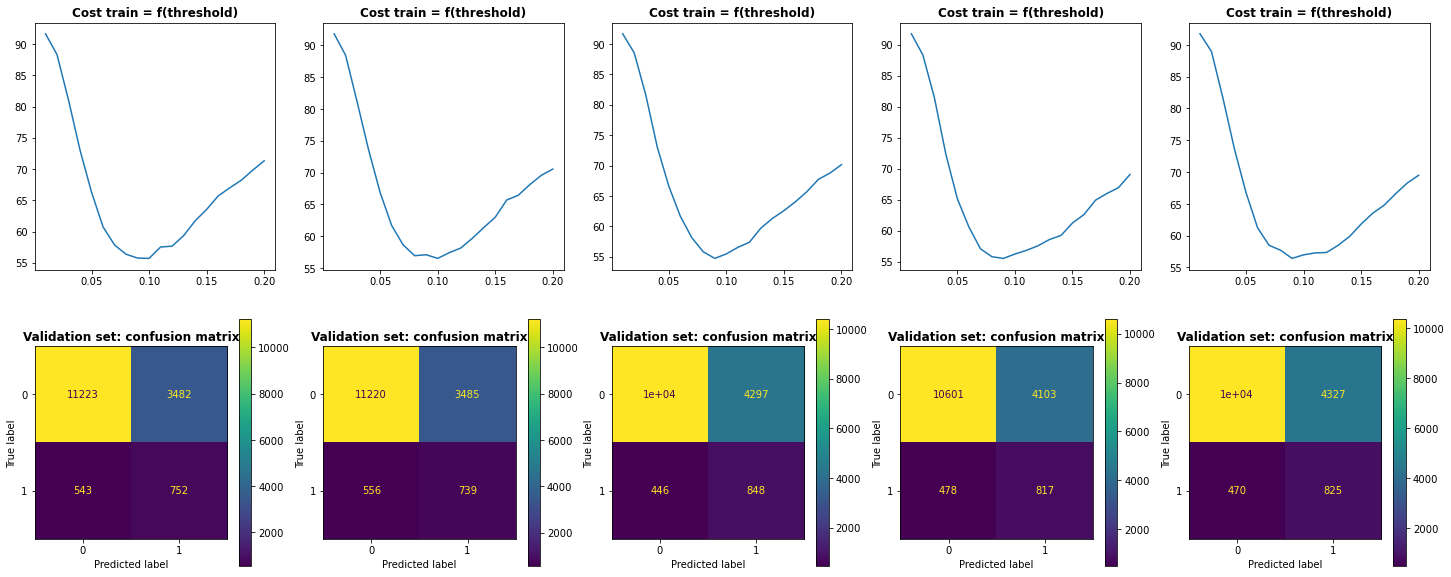

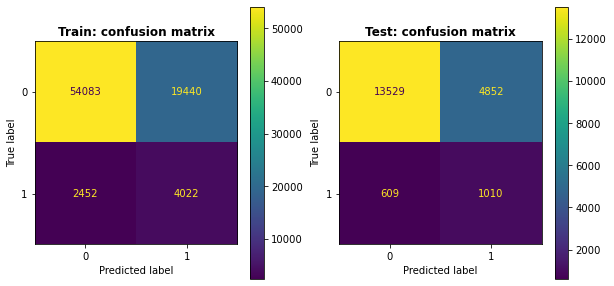

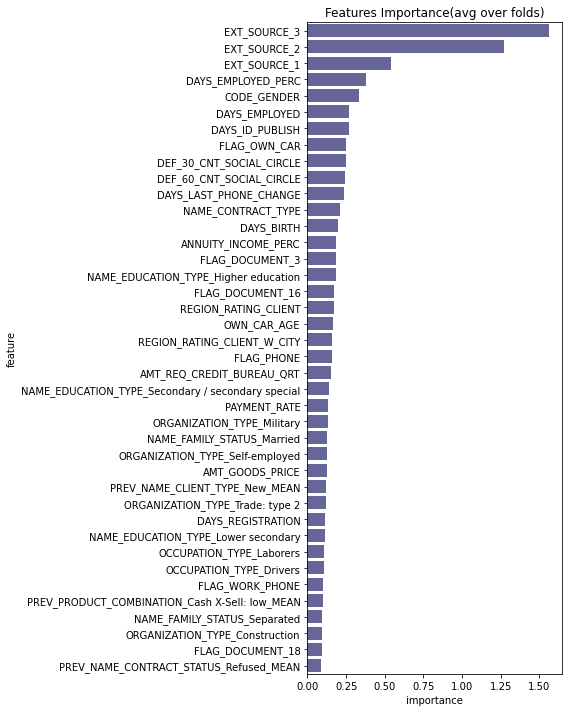

In [878]:
model1_Log_reg(data_transformed_100000)

## Idem - weight : balanced

In [773]:
import joblib
def Log_reg_balanced(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
         # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set[n_fold] = results_valid  
    result_validation = list(result_validation_set.mean(axis=1))  
    
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = LogisticRegression(max_iter=2000, C=0.01, class_weight='balanced') 
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_balanced_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [895]:
def model2_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression balanced"):
        Log_reg_balanced(df, num_folds=10, stratified=True)    

Threshold optimum: 0.5105263157894737
Threshold optimum: 0.5736842105263158
Threshold optimum: 0.5105263157894737
Threshold optimum: 0.4789473684210526
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.5105263157894737
Threshold optimum: 0.5894736842105264
Threshold optimum: 0.6210526315789473
Threshold optimum: 0.5105263157894737
Threshold optimum - Mean: 0.5373684210526315
           Validation      Train       Test
Accuracy     0.741750   0.746687   0.723500
Cost        53.950000  53.231250  57.350000
F1_score     0.270332   0.271698   0.259705
Precision    0.177988   0.175284   0.166096
Profit      38.225000  38.943750  34.500000
Recall       0.600717   0.603834   0.595092
roc_auc      0.737115   0.757544   0.735597
Run Logistic regression balanced - done in 8s


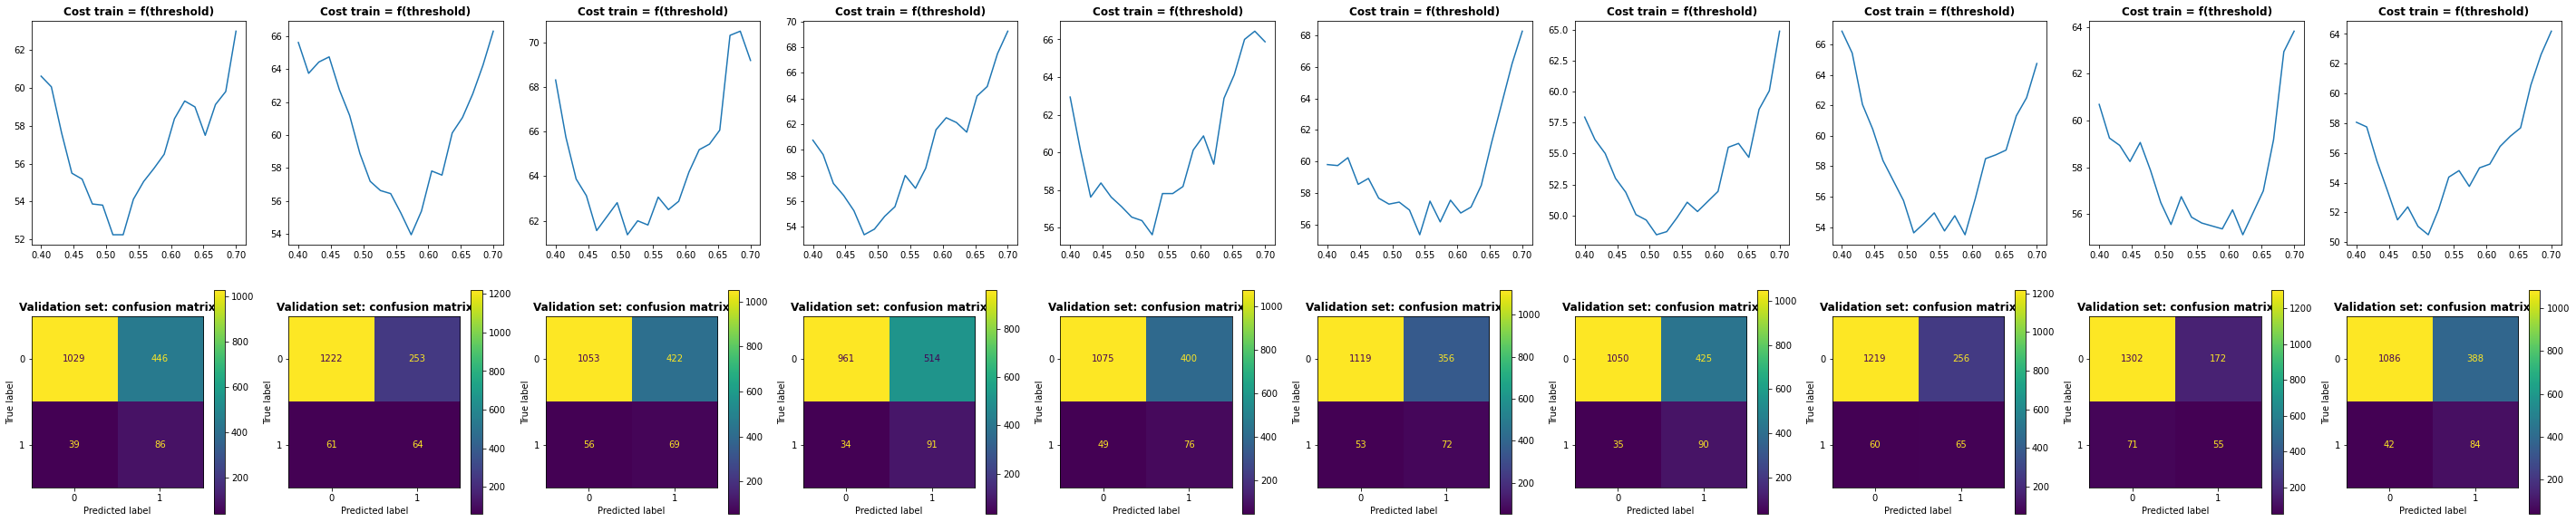

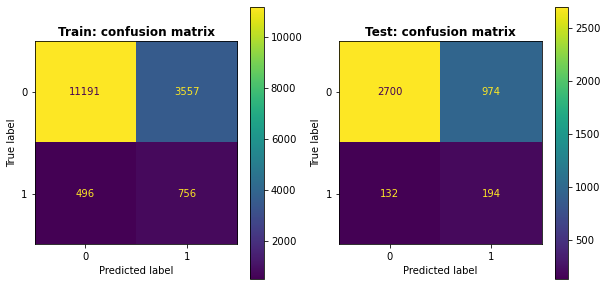

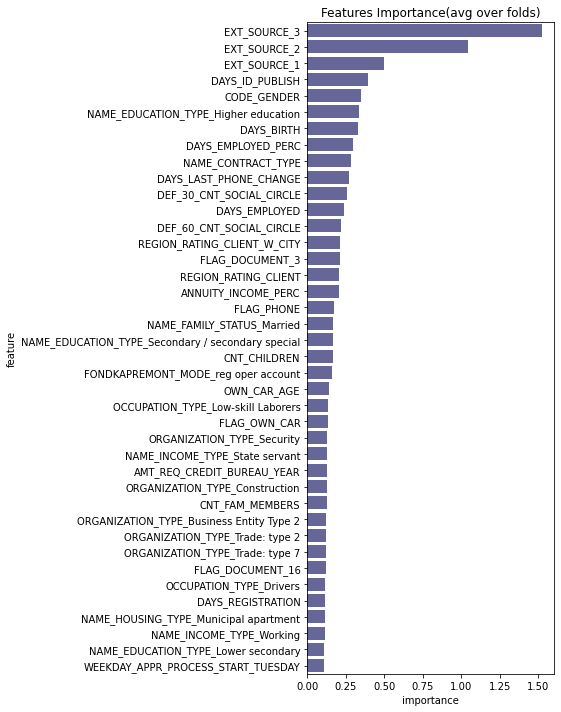

In [896]:
model2_Log_reg(data_transformed_20000)

In [523]:
saved_Log_reg_balanced_model = joblib.load('Log_reg_balanced_model.joblib')

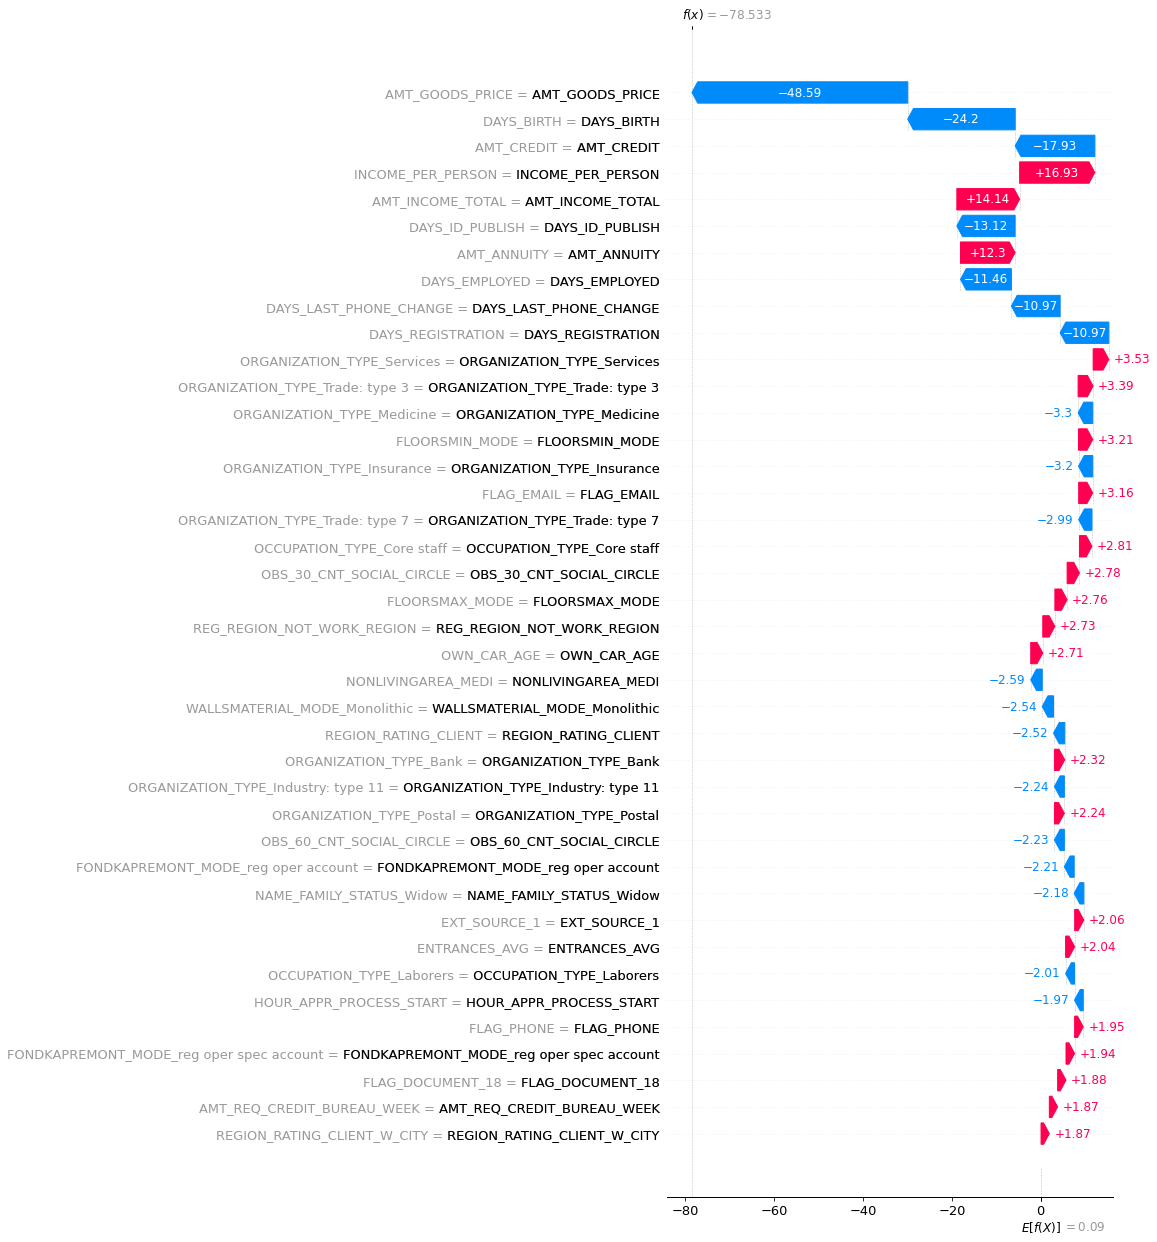

In [570]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(ssaved_Log_reg_balanced_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=ssaved_Log_reg_balanced_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

Threshold optimum: 0.5263157894736842
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.5105263157894737
Threshold optimum: 0.49473684210526314
Threshold optimum - Mean: 0.523157894736842
               Train       Test
Accuracy    0.718089   0.722550
Cost       54.427041  54.160000
F1_score    0.268884   0.270157
Precision   0.170189   0.171481
Profit     37.473905  37.770000
Recall      0.640068   0.636307
roc_auc     0.750955   0.745790
Run Logistic regression balanced - done in 95s


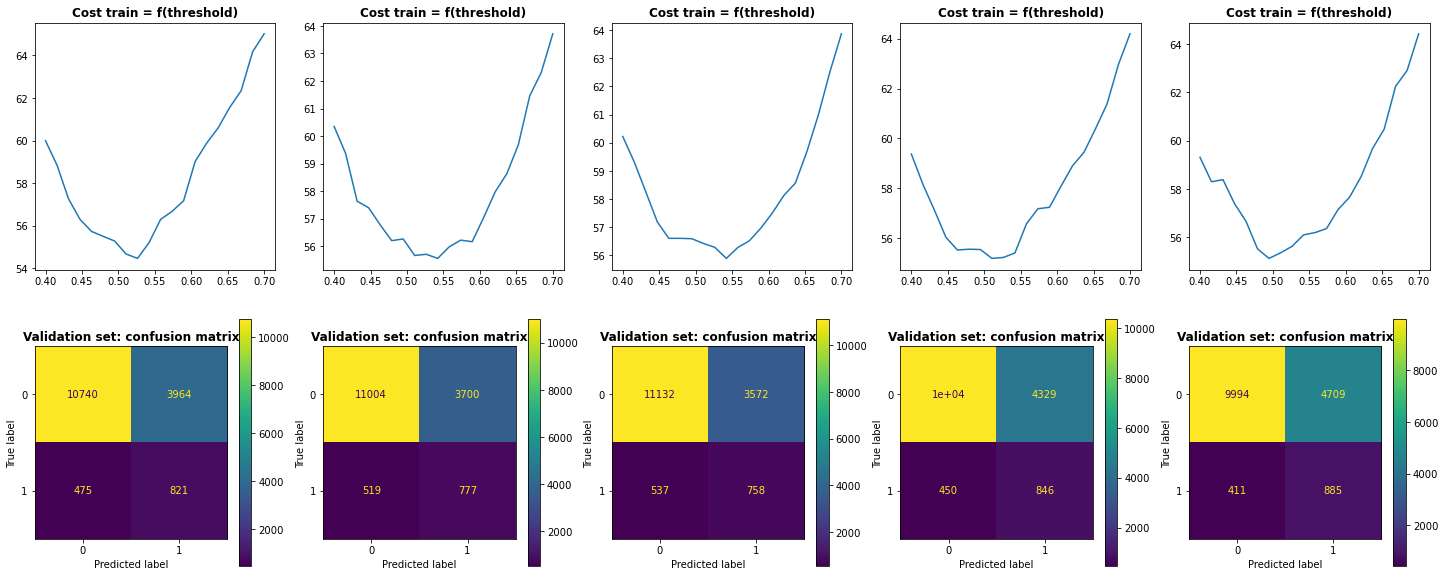

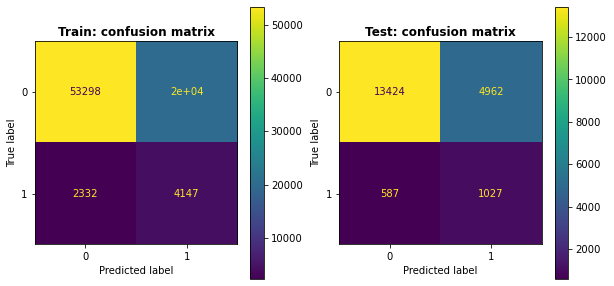

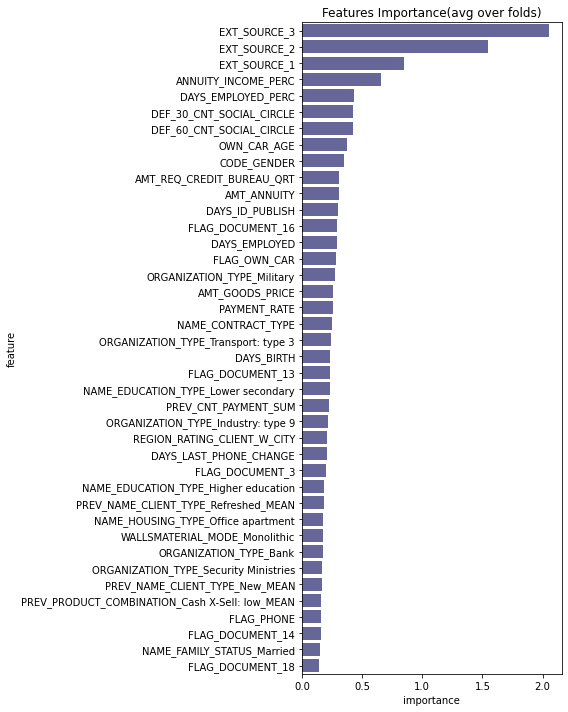

In [729]:
model2_Log_reg(data_transformed_100000)

## Idem - Balanced with smote 

In [189]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [776]:
def Log_reg_smote(df, num_folds, stratified = False):
    from imblearn.pipeline import Pipeline
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    if stratified:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
   
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = LogisticRegression(max_iter=2000) 
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
       # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].coef_[0]
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = LogisticRegression(max_iter=2000) 
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    filename = 'Log_reg_smote_model.joblib'
    joblib.dump(pipe, filename)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [897]:
def model3_Log_reg(df, num_folds=10, stratified = True):
    with timer("Run Logistic regression smote"):
        Log_reg_smote(df, num_folds=10, stratified = True)

Threshold optimum: 0.5736842105263158
Threshold optimum: 0.5578947368421052
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.43157894736842106
Threshold optimum: 0.5263157894736842
Threshold optimum: 0.5421052631578948
Threshold optimum: 0.49473684210526314
Threshold optimum: 0.5894736842105264
Threshold optimum: 0.5736842105263158
Threshold optimum: 0.5736842105263158
Threshold optimum - Mean: 0.5405263157894737
           Validation      Train       Test
Accuracy     0.792500   0.830187   0.813250
Cost        51.687500  54.500000  61.425000
F1_score     0.299578   0.301003   0.266928
Precision    0.204023   0.222011   0.196248
Profit      40.437500  37.675000  30.425000
Recall       0.563492   0.467252   0.417178
roc_auc      0.749106   0.761668   0.726857
Run Logistic regression smote - done in 24s


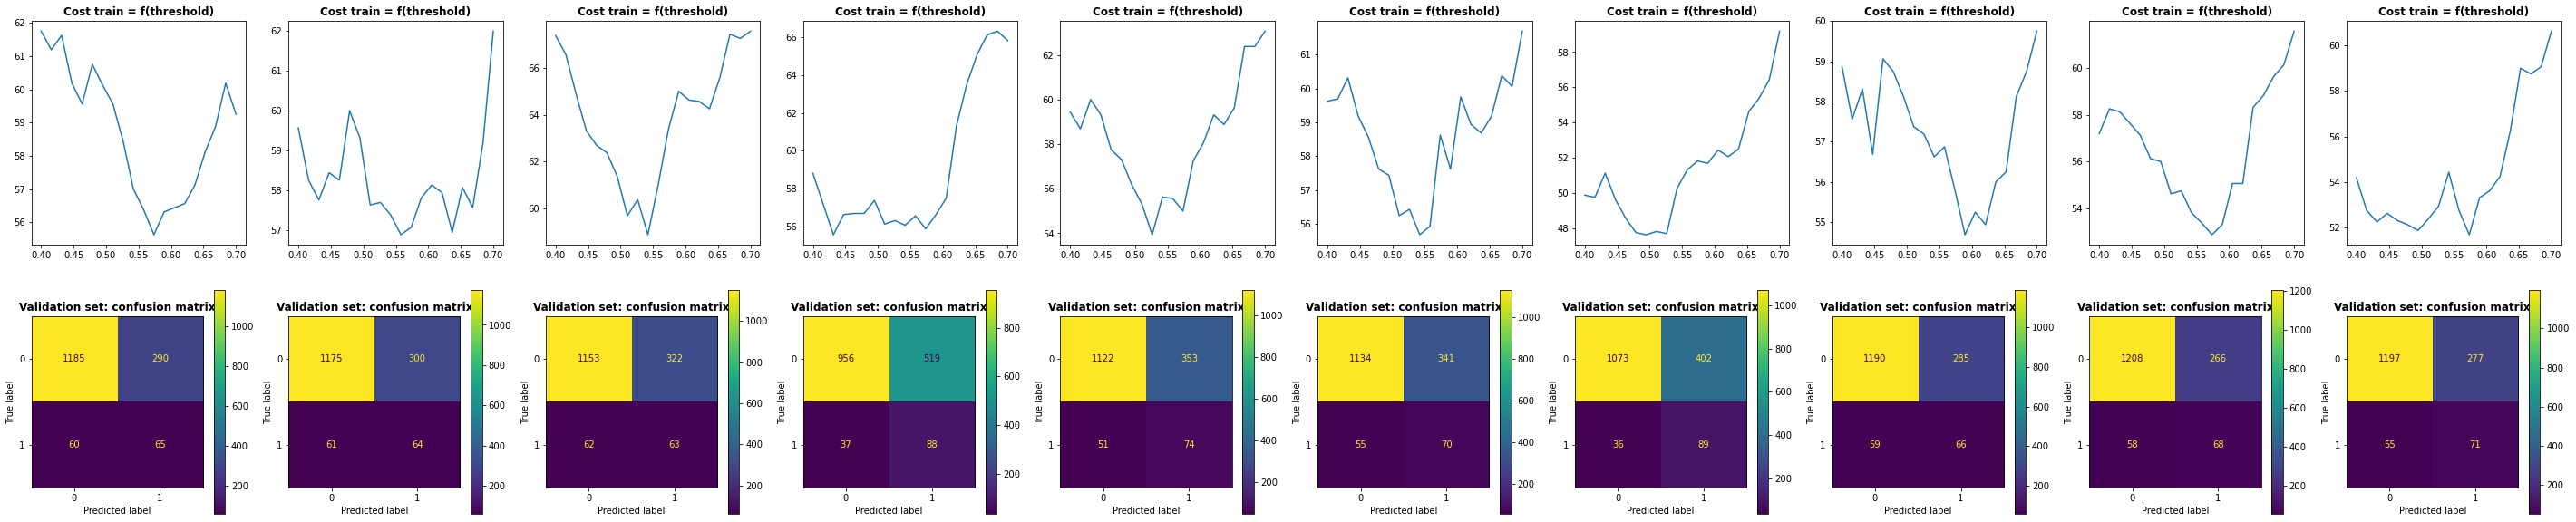

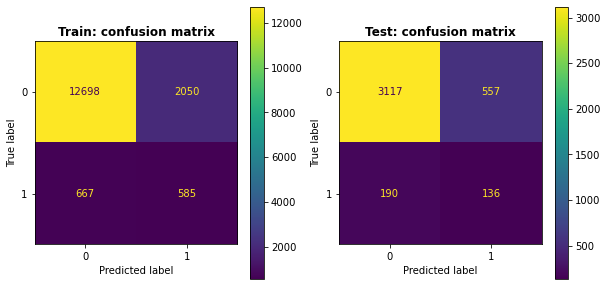

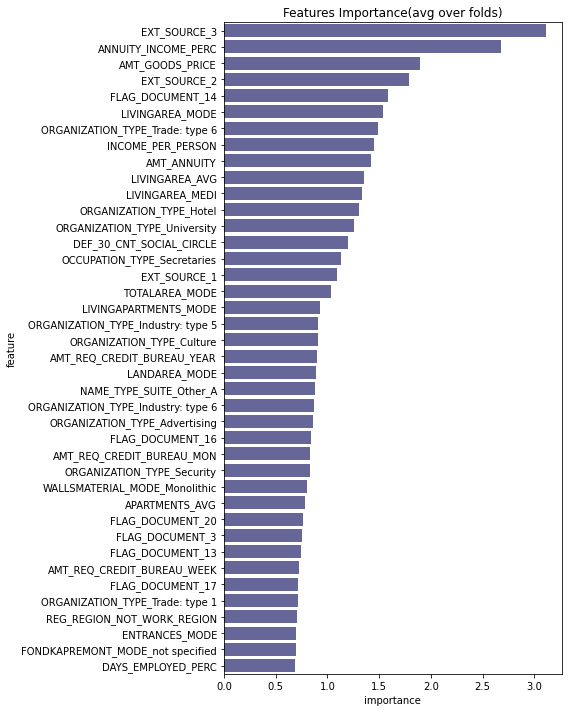

In [898]:
model3_Log_reg(data_transformed_20000)

In [779]:
saved_Log_reg_smote_model = joblib.load('Log_reg_smote_model.joblib')

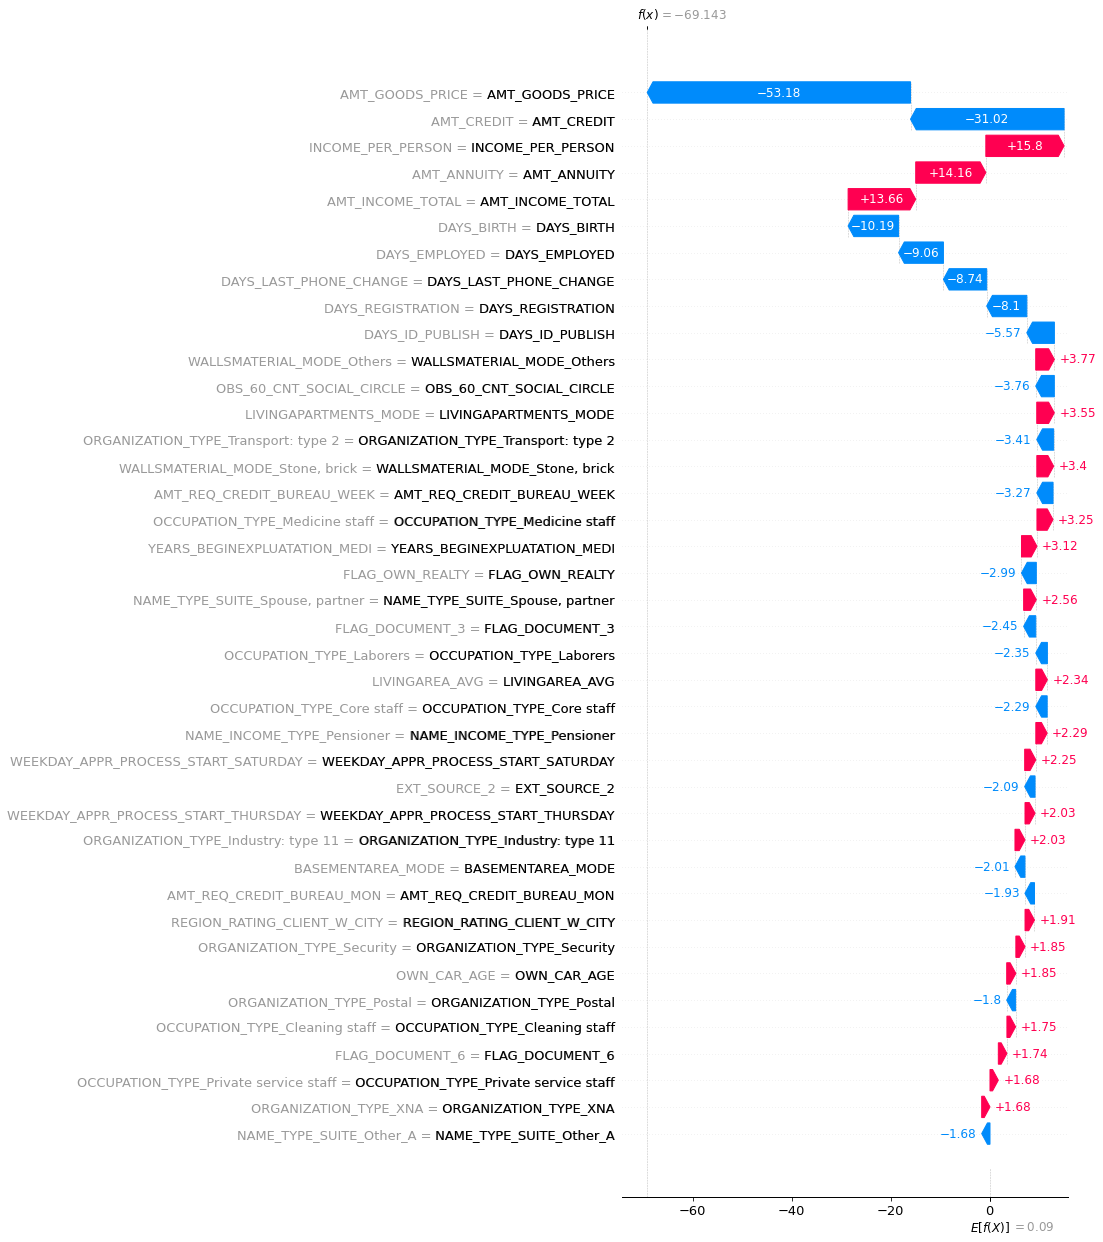

In [780]:
sample = shap.utils.sample(X_train, nsamples=100)
explainer = shap.KernelExplainer(saved_Log_reg_smote_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Log_reg_smote_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

Threshold optimum: 0.5105263157894737
Threshold optimum: 0.5105263157894737
Threshold optimum: 0.4789473684210526
Threshold optimum: 0.49473684210526314
Threshold optimum: 0.43157894736842106
Threshold optimum - Mean: 0.4852631578947369
               Train       Test
Accuracy    0.796505   0.796850
Cost       55.810843  56.945000
F1_score    0.290150   0.282536
Precision   0.202200   0.197580
Profit     36.090103  34.985000
Recall      0.513505   0.495663
roc_auc     0.749358   0.734329
Run Logistic regression smote - done in 230s


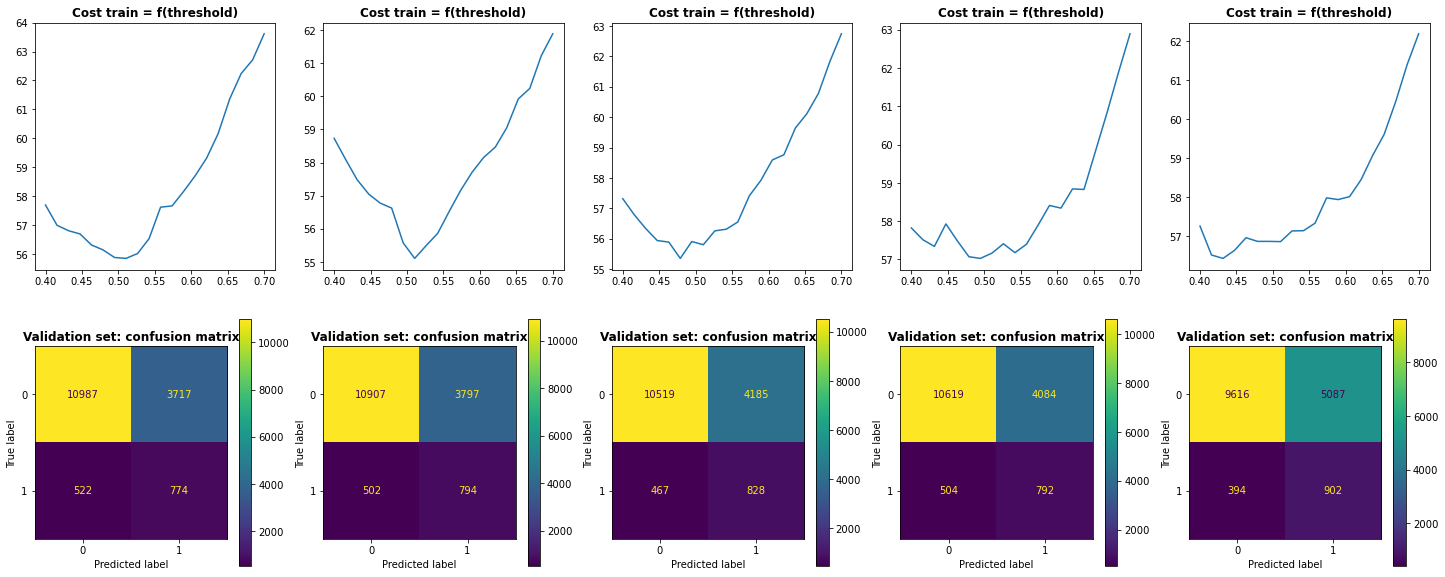

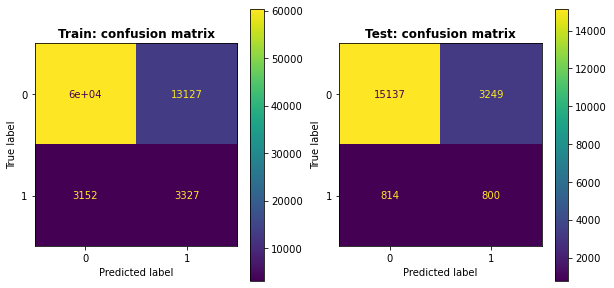

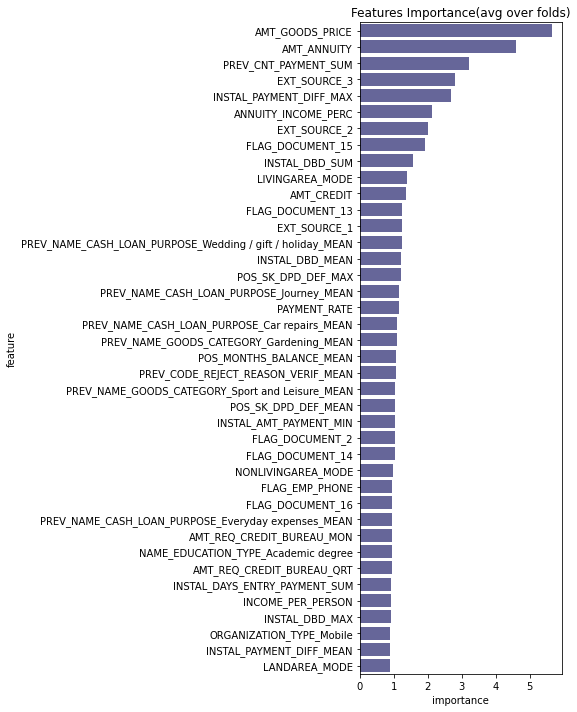

In [725]:
model3_Log_reg(data_transformed_100000)

# Model téléchargé
## lightgbm - Balanced

In [781]:
def lightgbm(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, 
            class_weight='balanced')
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
       
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        class_weight='balanced')
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'lightgbm_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [782]:
def model4(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        lightgbm(df, num_folds, stratified)

Threshold optimum: 0.13684210526315788
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.05
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.10789473684210524
           Validation      Train       Test
Accuracy     0.720625   0.908500   0.780500
Cost        59.437500   9.150000  62.000000
F1_score     0.219895   0.619147   0.293076
Precision    0.138767   0.448380   0.206349
Profit      33.125000  83.412500  29.000000
Recall       0.529412   1.000000   0.505556
roc_auc      0.679492   1.000000   0.724615
Run Logistic regression balanced - done in 129s


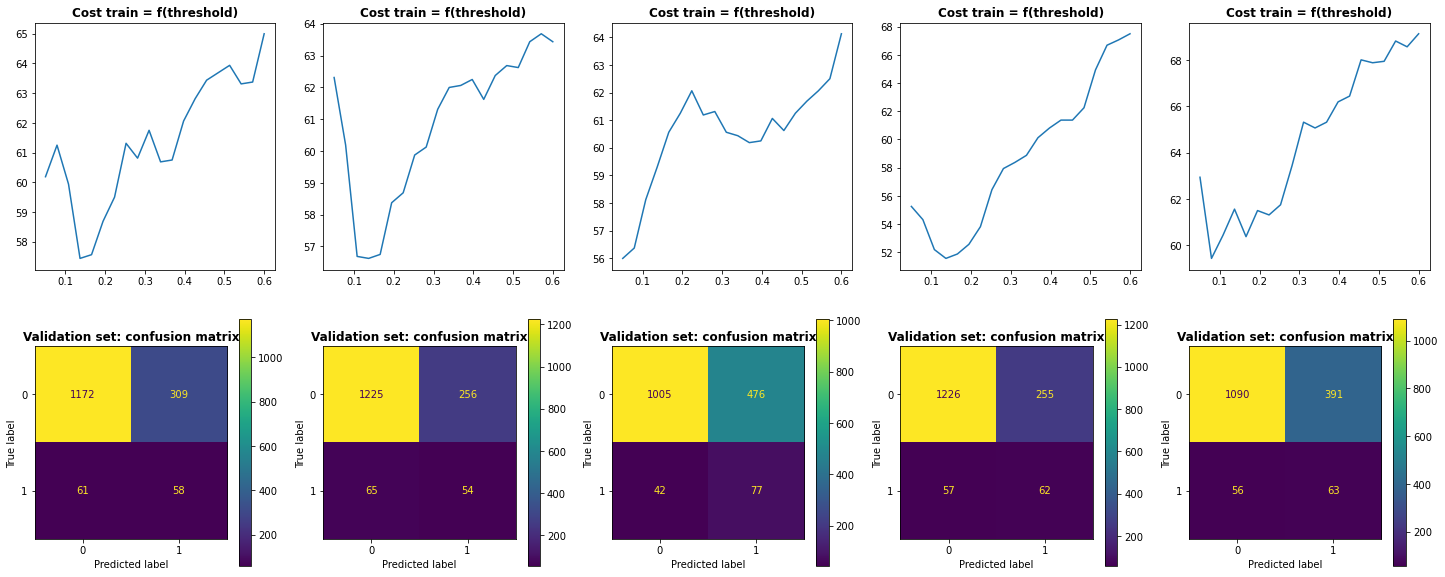

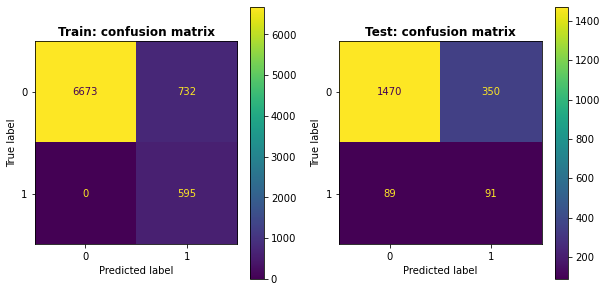

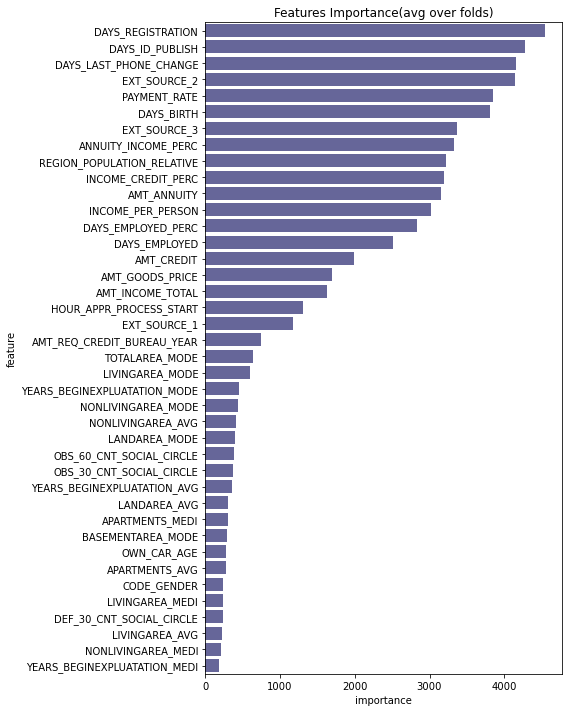

In [783]:
model4(data_transformed)

In [80]:
# Important overfitting

In [542]:
saved_lightgbm_model = joblib.load('lightgbm_model.joblib')

In [600]:
saved_lightgbm_model

Pipeline(steps=[('scl', MinMaxScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=0.9497036, learning_rate=0.02,
                                max_depth=8, min_child_weight=39.3259775,
                                min_split_gain=0.0222415, n_estimators=10000,
                                num_leaves=34, silent=-1, subsample=0.8715623,
                                verbose=-1))])

In [877]:
#sample = shap.utils.sample(X_train, nsamples=10)
#explainer = shap.KernelExplainer(saved_lightgbm_model['model'].predict_proba, sample)
#X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_lightgbm_model['scl'].transform(X_test))
#i=1
#test_example = np.array(X_test_transformed.iloc[i, :])
#shap_values = explainer.shap_values(test_example)
#features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=shap_values[0])
#features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
#features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
#expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

#shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=10, show=True)

In [659]:
test_example.shape

(242,)

## lightgbm with smote 

In [784]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def lightgbm_smote(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.6, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=25,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=4,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")


    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [785]:
def model4_bis(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        lightgbm_smote(df, num_folds, stratified)

Threshold optimum: 0.22368421052631576
Threshold optimum: 0.22368421052631576
Threshold optimum: 0.2526315789473684
Threshold optimum: 0.19473684210526315
Threshold optimum: 0.31052631578947365
Threshold optimum - Mean: 0.24105263157894735
           Validation      Train       Test
Accuracy     0.992500   0.970750   0.863500
Cost         0.750000   2.925000  69.000000
F1_score     0.952000   0.835674   0.294574
Precision    0.908397   0.717732   0.275362
Profit      91.812500  89.637500  22.000000
Recall       1.000000   1.000000   0.316667
roc_auc      0.999052   0.997516   0.716123
Run Logistic regression balanced - done in 199s


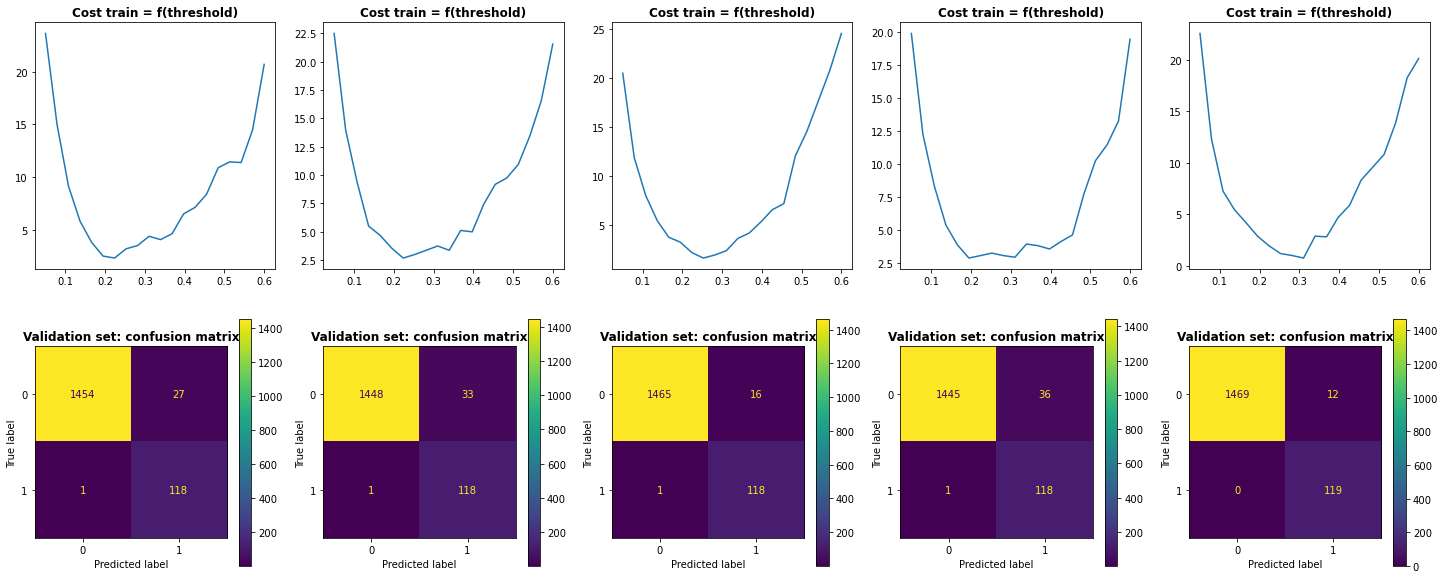

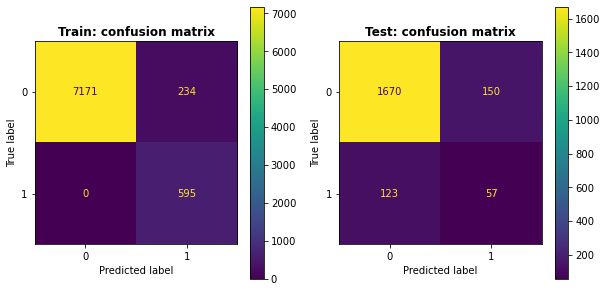

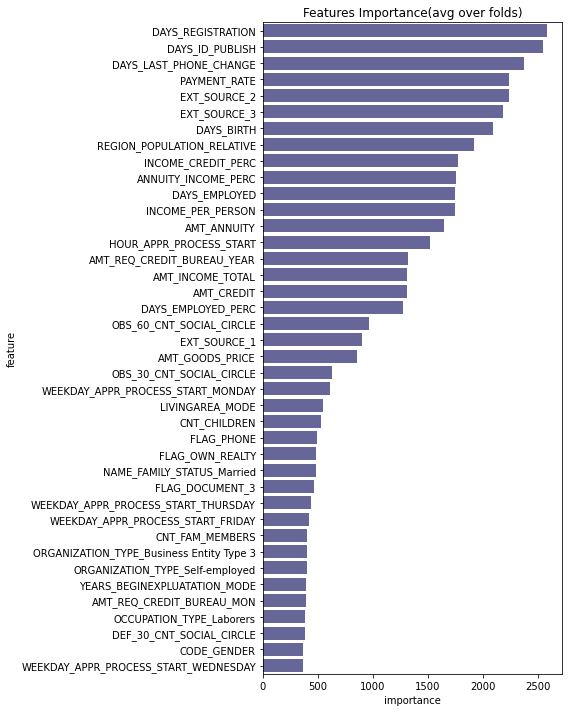

In [786]:
model4_bis(data_transformed)

In [84]:
# Important overfitting

## lightgbm calibrated 
### Data filled

In [787]:
from sklearn.calibration import CalibratedClassifierCV
def lightgbm_calibrated(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.feature_importances_
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")


    scl = MinMaxScaler()
    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation,  results_test))
   
    display_importances(feature_importance_df) 
    
    

In [880]:
def model4_qua(df, num_folds=10, stratified = True):
    with timer("Run lightgbm_calibrated"):
        lightgbm_calibrated(df, num_folds, stratified)

Threshold optimum: 0.10789473684210527
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.10210526315789474
           Validation      Train       Test
Accuracy     0.708750   0.878500   0.790000
Cost        53.875000  12.262500  61.050000
F1_score     0.245955   0.550000   0.302326
Precision    0.152610   0.379553   0.215640
Profit      38.625000  80.300000  29.950000
Recall       0.633333   0.998319   0.505556
roc_auc      0.746408   0.992844   0.734928
Run lightgbm_calibrated - done in 498s


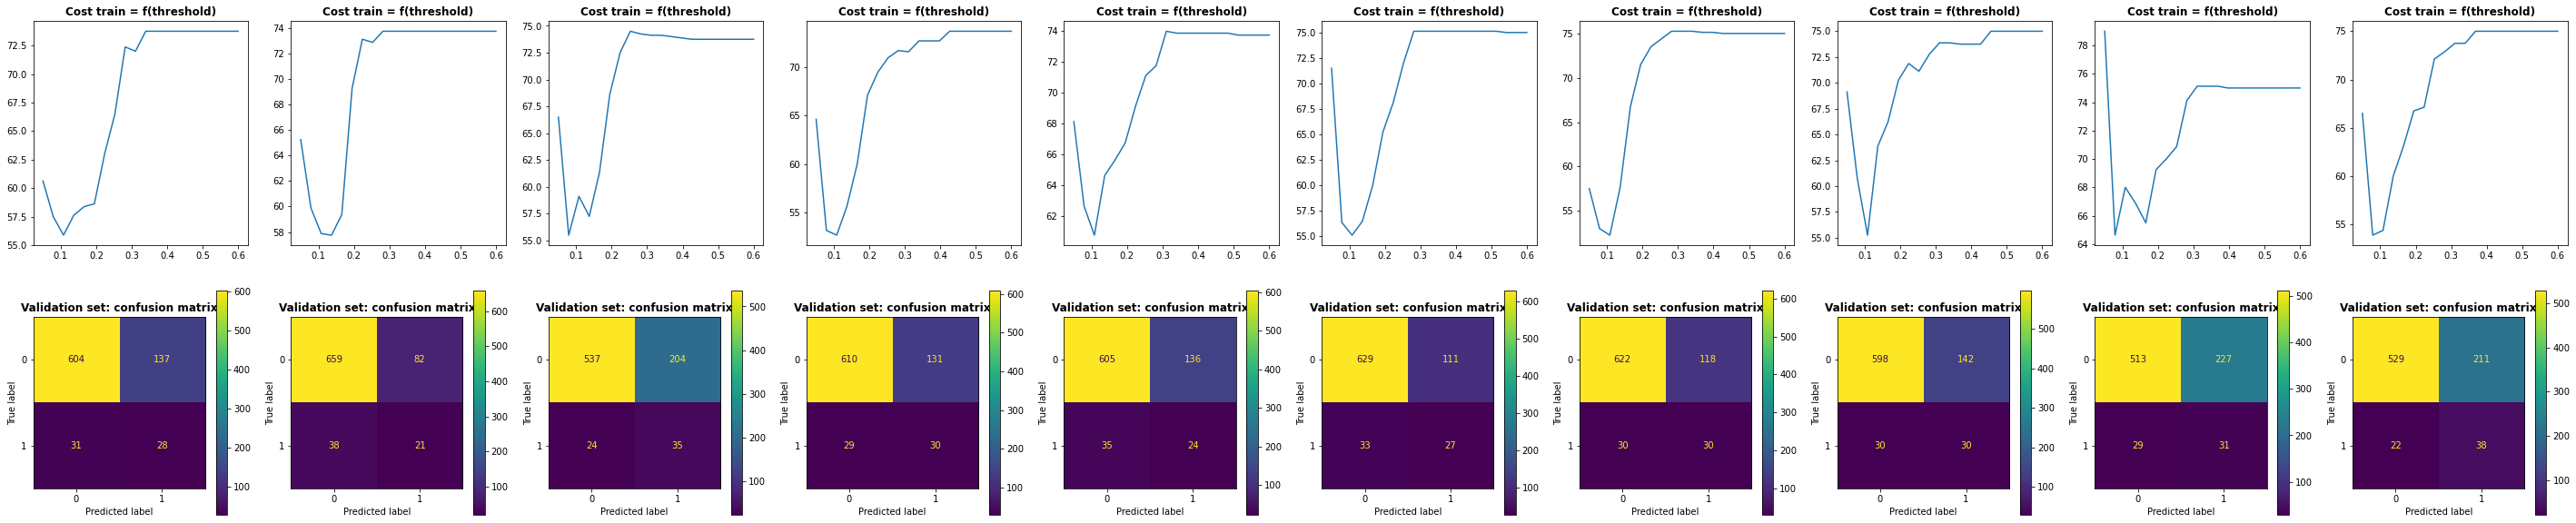

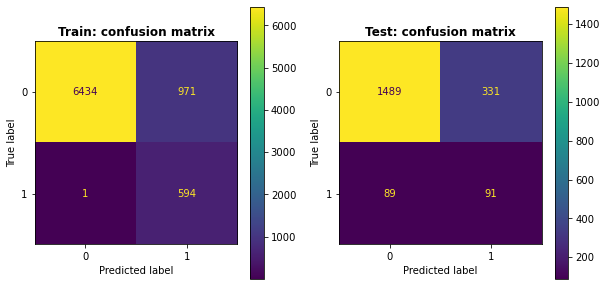

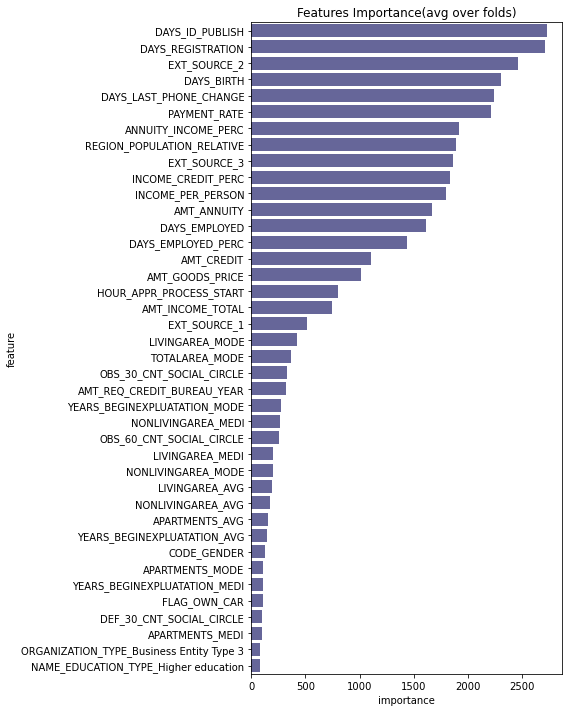

In [899]:
model4_qua(data_transformed)

### Data unfilled

In [790]:
from sklearn.calibration import CalibratedClassifierCV
def lightgbm_calibrated2(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.feature_importances_
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    regressor = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [900]:
def model4_quin(df, num_folds=10, stratified = True):
    with timer("Run lightgbm_calibrated2"):
        lightgbm_calibrated2(df, num_folds, stratified)

Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09052631578947368
           Validation      Train       Test
Accuracy     0.685000   0.823500   0.758500
Cost        49.500000  17.762500  57.000000
F1_score     0.258824   0.456923   0.307030
Precision    0.157143   0.296259   0.206963
Profit      43.000000  74.800000  34.000000
Recall       0.733333   0.998319   0.594444
roc_auc      0.738480   0.995207   0.744983
Run lightgbm_calibrated2 - done in 2184s


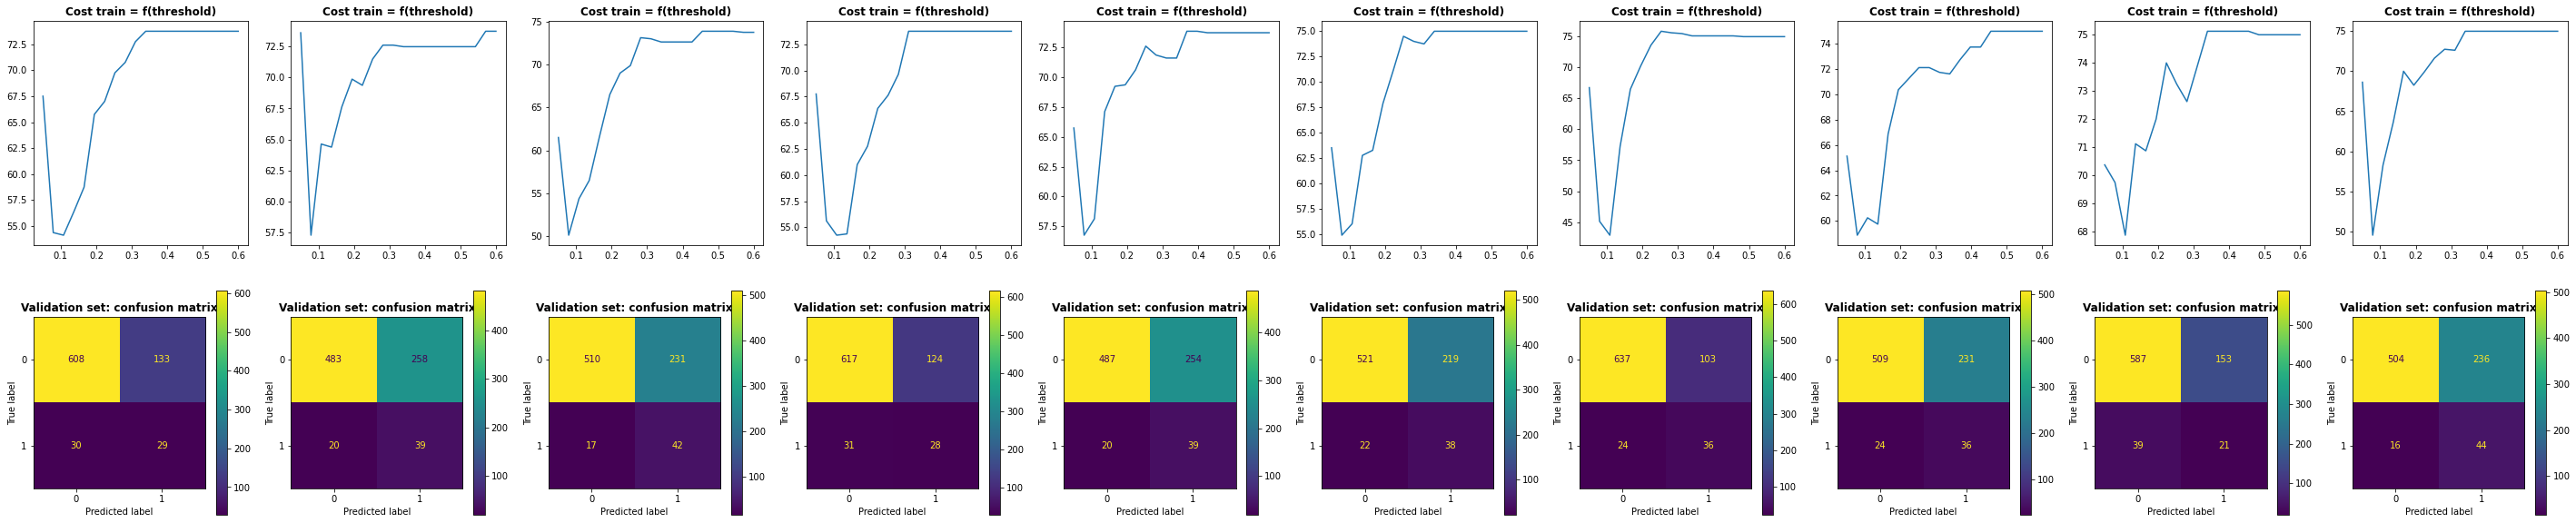

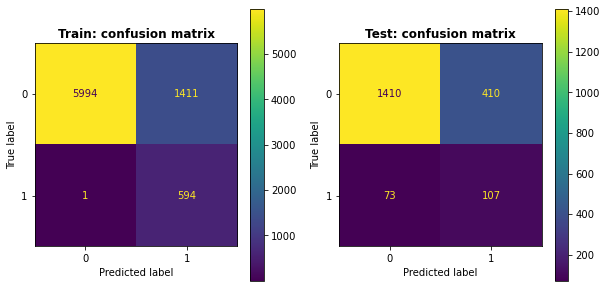

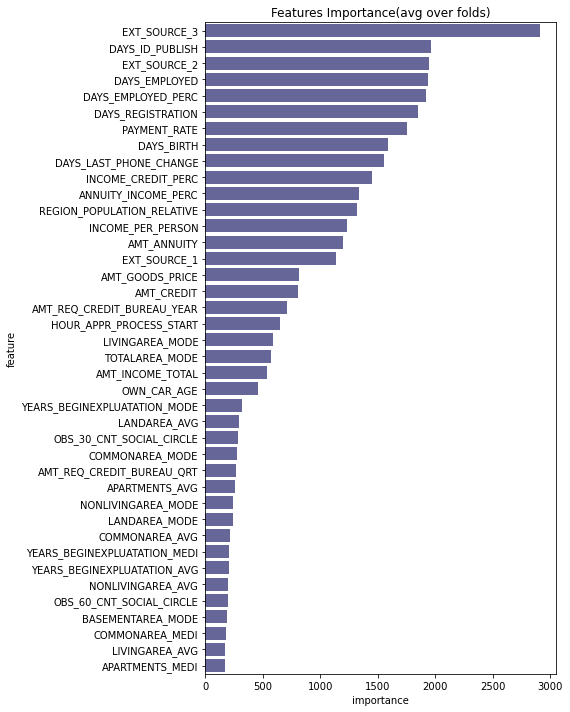

In [901]:
model4_quin(data_transformed_unfilled)

## BayesianOptimization hyperparameters

In [85]:
def clf_result(clf, df, num_folds, stratified = False, debug= False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X1 = df1[df1['TARGET'].notnull()]
    X = X1.drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    if stratified:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
  
    param_grid = {'model__n_estimators': [1000]}
    
    steps = [('model', clf)]
 
    pipe = Pipeline(steps)
    gsc = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=custom_score, cv=num_folds)
    
    gsc.fit(X_train, y_train)
    
    return gsc.cv_results_['mean_test_score'][0]

In [86]:
def bo_params_rf(learning_rate,
            num_leaves,
            colsample_bytree,
            subsample,
            max_depth,
            min_split_gain,
            min_child_weight):
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'max_depth': int(max_depth),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
    }
    clf = LGBMClassifier(n_estimators=10000,
            learning_rate=params['learning_rate'],
            num_leaves=params['num_leaves'],
            colsample_bytree=params['colsample_bytree'],
            subsample=params['subsample'],
            max_depth=params['max_depth'],
            min_split_gain=params['min_split_gain'],
            min_child_weight=params['min_child_weight'])
    score = clf_result(clf, data_transformed_unfilled, 5)
    return score

In [87]:
import bayes_opt
from bayes_opt import BayesianOptimization
rf_bo = BayesianOptimization(bo_params_rf, {'learning_rate':(0.001, 0.1),
            'num_leaves': (10, 100),
            'colsample_bytree': (0.6, 1),
            'subsample': (0.75, 0.95),
            'max_depth': (5, 5),
            'min_split_gain': (0.001, 0.1),
            'min_child_weight': (20, 50)})

In [126]:
#results = rf_bo.maximize(n_iter=20, init_points=10, acq='ei')

# SVM

In [794]:
def SVC_calibrated(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.coef_[0]
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = SVC(kernel='linear', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'saved_SVC_calibrated_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    

In [888]:
def model9(df, num_folds=10, stratified = True):
    with timer("Run SVC_calibrated"):
        SVC_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.08763157894736842
           Validation      Train       Test
Accuracy     0.660000   0.800250   0.789000
Cost        68.875000  60.925000  72.850000
F1_score     0.175758   0.224272   0.235507
Precision    0.107407   0.157679   0.174731
Profit      23.625000  31.637500  18.150000
Recall       0.483333   0.388235   0.361111
roc_auc      0.609932   0.685251   0.650777
Run SVC_calibrated - done in 214s


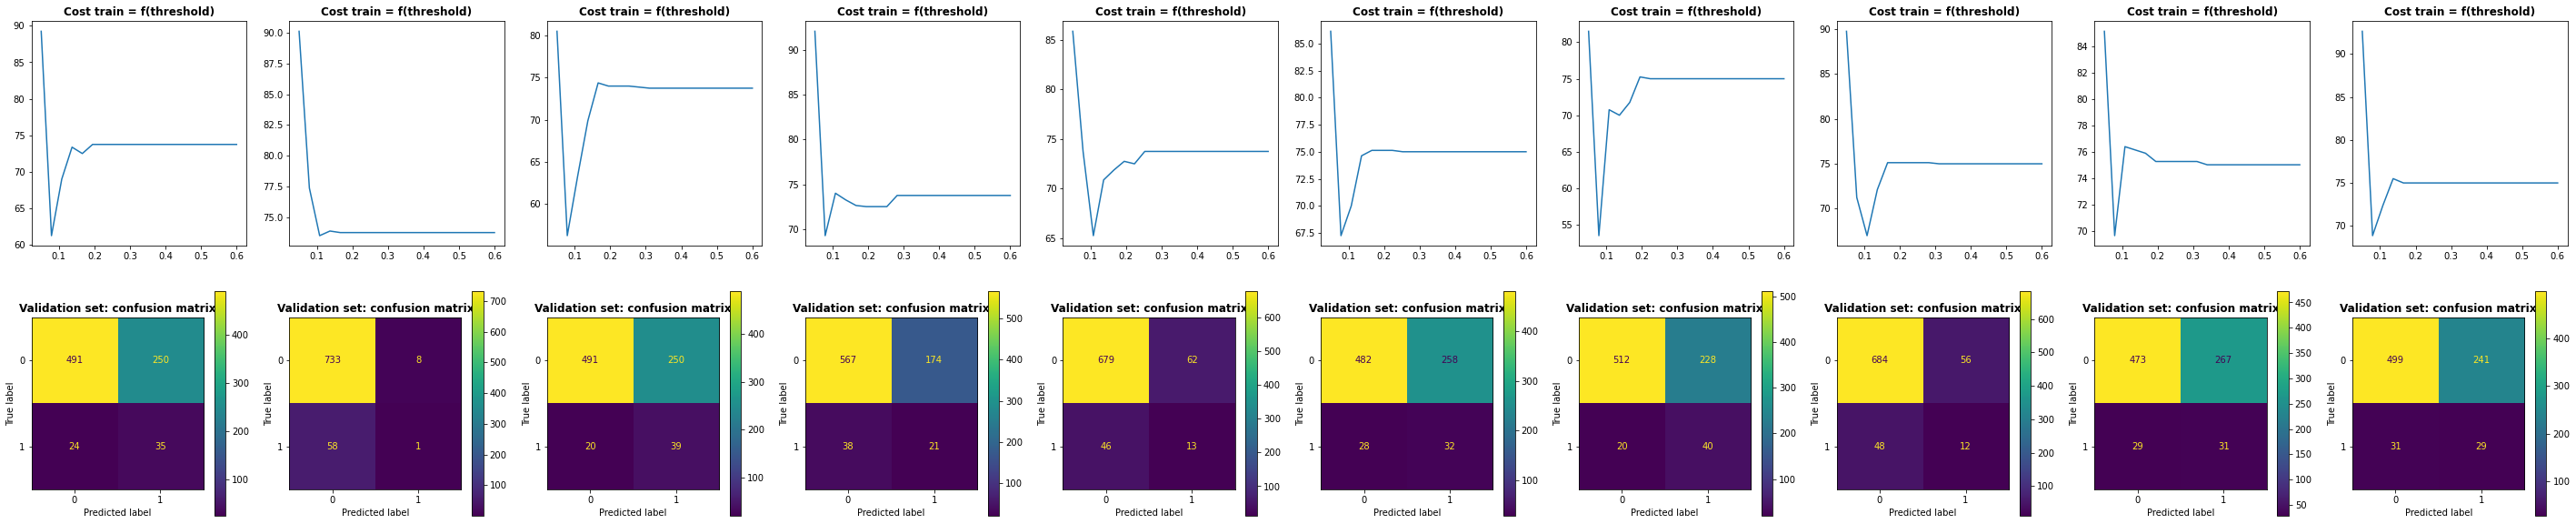

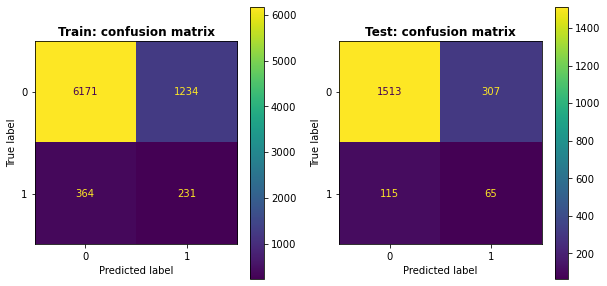

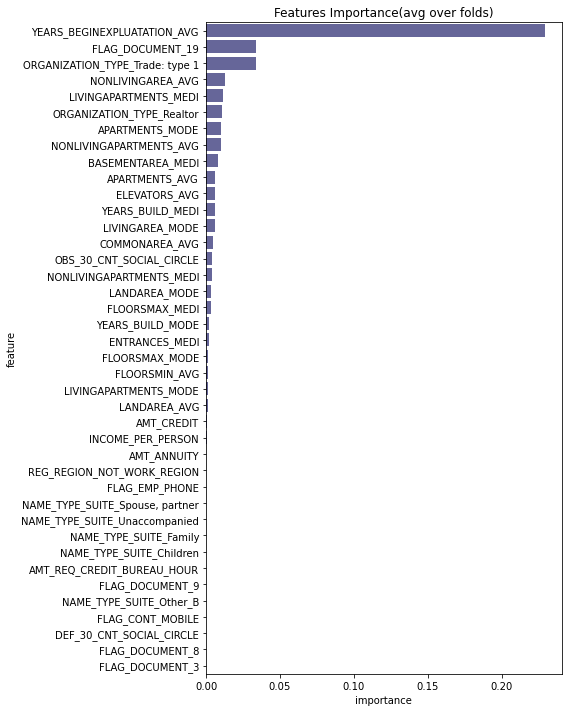

In [889]:
model9(data_transformed)

In [797]:
saved_SVC_calibrated_model = joblib.load('saved_SVC_calibrated_model.joblib')

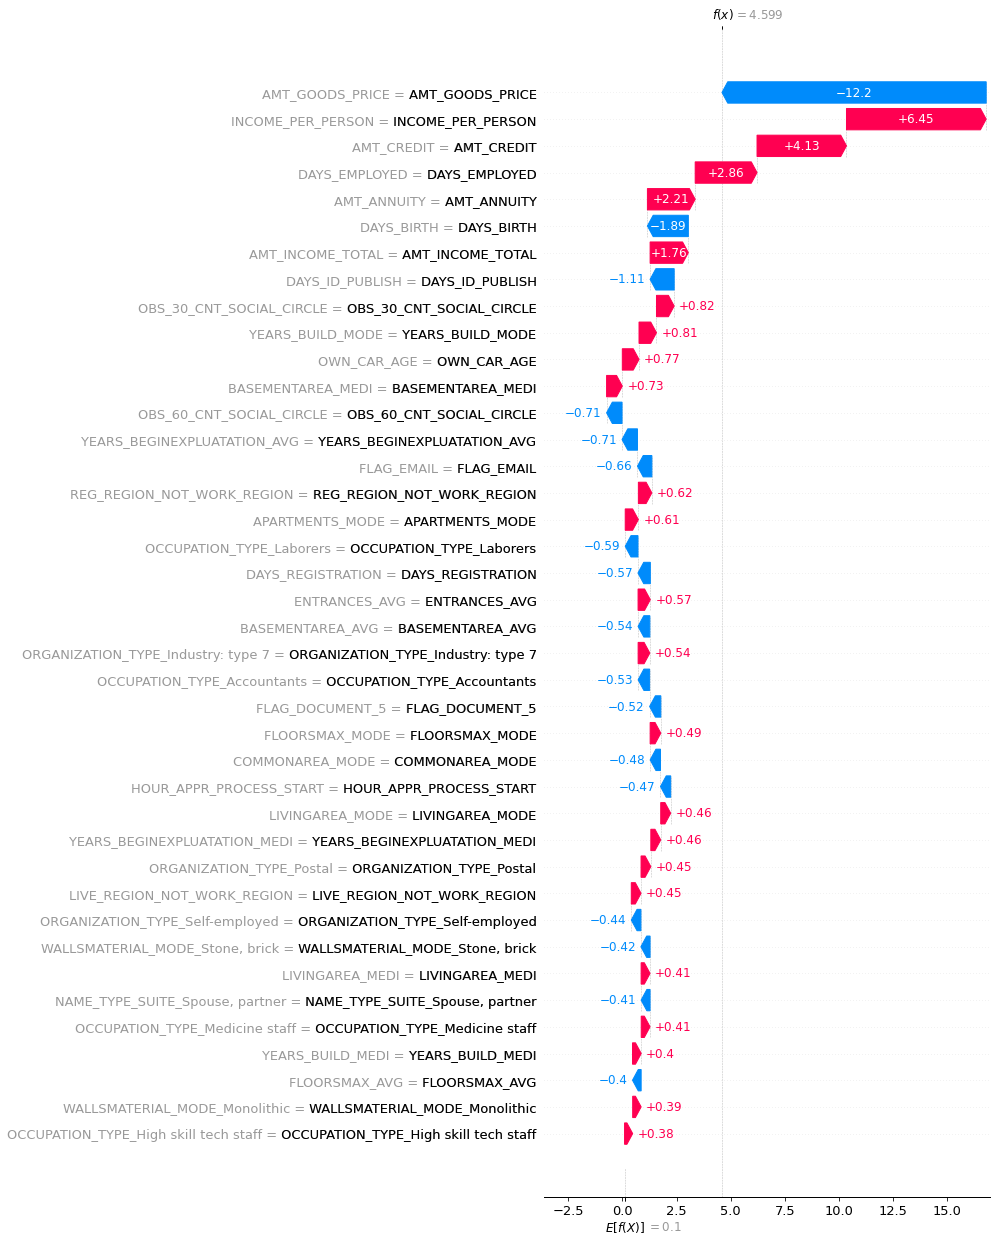

In [799]:
sample = shap.utils.sample(X_train, nsamples=50)
explainer = shap.KernelExplainer(saved_SVC_calibrated_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_SVC_calibrated_model['scl'].transform(X_test))
i=3
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

In [800]:
import shap
import random
def SVC_rbf(df, num_folds, stratified = False):
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
        # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = SVC(kernel='rbf', 
                    degree=2, 
                    gamma='scale',  
                    probability=False, 
                    tol=0.001,  
                    random_state=41)
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'SVC_rbf_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
    

In [801]:
def model_SVC_rbf(df, num_folds=5, stratified = True):
    with timer("Run SVC_rbf"):
        SVC_rbf(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.0905263157894737
           Validation      Train       Test
Accuracy     0.653750   0.901125   0.762500
Cost        61.062500  14.950000  60.650000
F1_score     0.206304   0.581703   0.292101
Precision    0.124352   0.424383   0.199593
Profit      31.500000  77.612500  30.350000
Recall       0.605042   0.924370   0.544444
roc_auc      0.677588   0.971328   0.721850
Run SVC_rbf - done in 102s


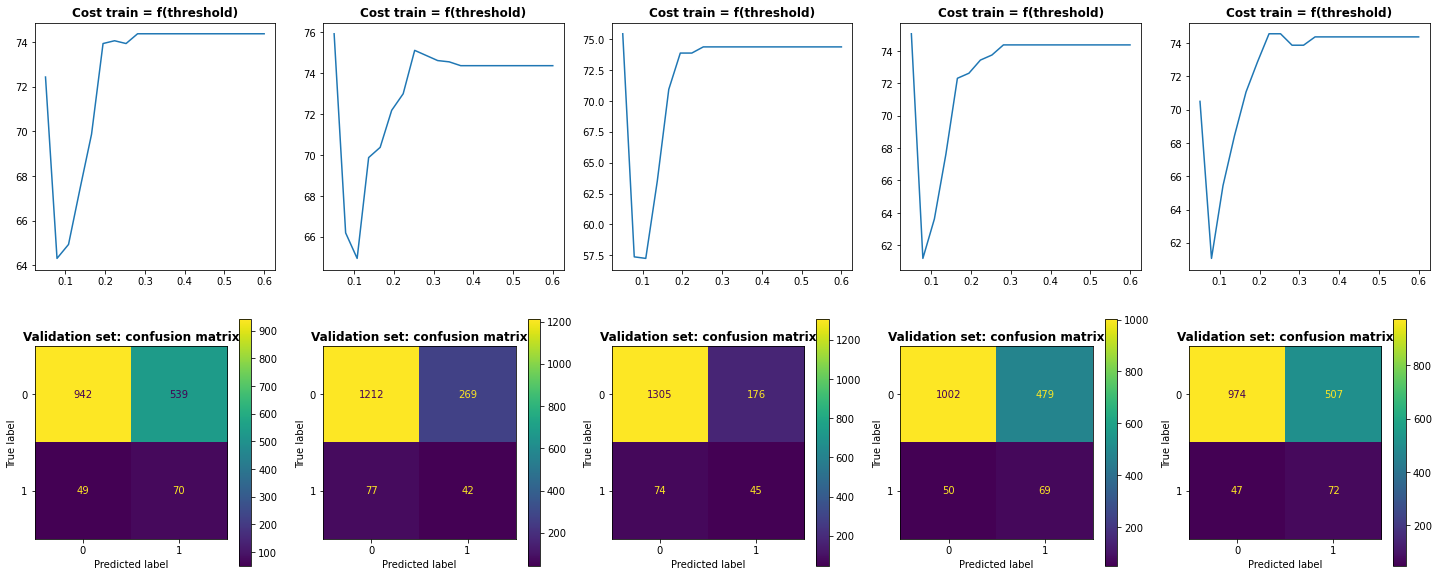

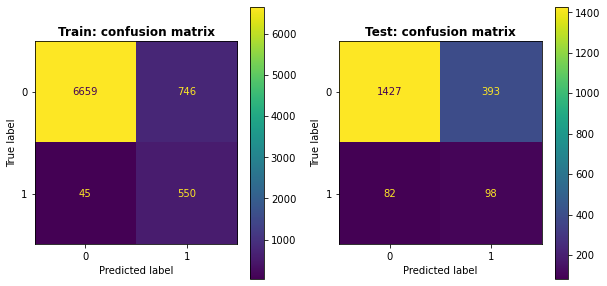

In [802]:
model_SVC_rbf(data_transformed)

In [803]:
saved_SVC_rbf_model = joblib.load('SVC_rbf_model.joblib')

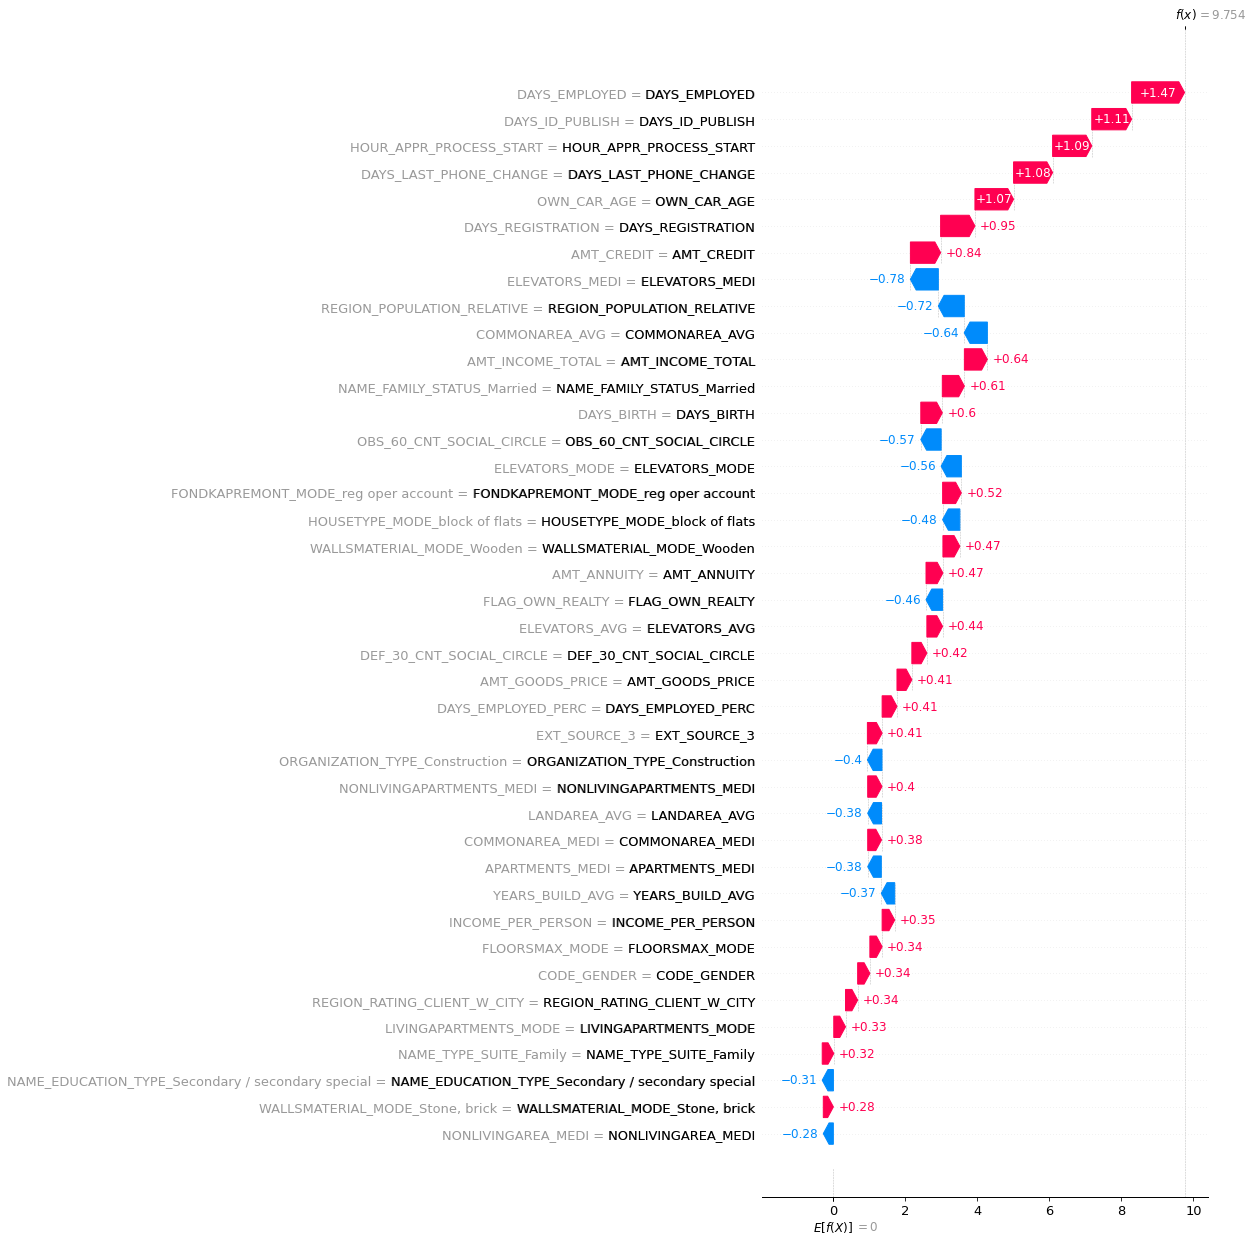

In [804]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.KernelExplainer(saved_SVC_rbf_model['model'].predict_proba, sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_SVC_rbf_model['scl'].transform(X_test))
i=861
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

# Tree
## Decision Tree

In [806]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree(df, num_folds, stratified = False):
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=4, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
            
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.2, 0.7, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=40, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                           class_weight='balanced')
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'Decision_Tree_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    
    

In [807]:
def model_decision_tree_balanced(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        Decision_Tree(df, num_folds, stratified)

Threshold optimum: 0.5684210526315789
Threshold optimum: 0.5947368421052632
Threshold optimum: 0.5157894736842106
Threshold optimum: 0.4631578947368421
Threshold optimum: 0.4631578947368421
Threshold optimum - Mean: 0.5210526315789474
           Validation      Train       Test
Accuracy     0.667188   0.943937   0.820500
Cost        59.437500   5.606250  76.450000
F1_score     0.228820   0.736254   0.155294
Precision    0.139823   0.582597   0.125954
Profit      32.718750  86.568750  15.400000
Recall       0.629482   1.000000   0.202454
roc_auc      0.687344   0.992045   0.539982
Run Logistic regression balanced - done in 6s


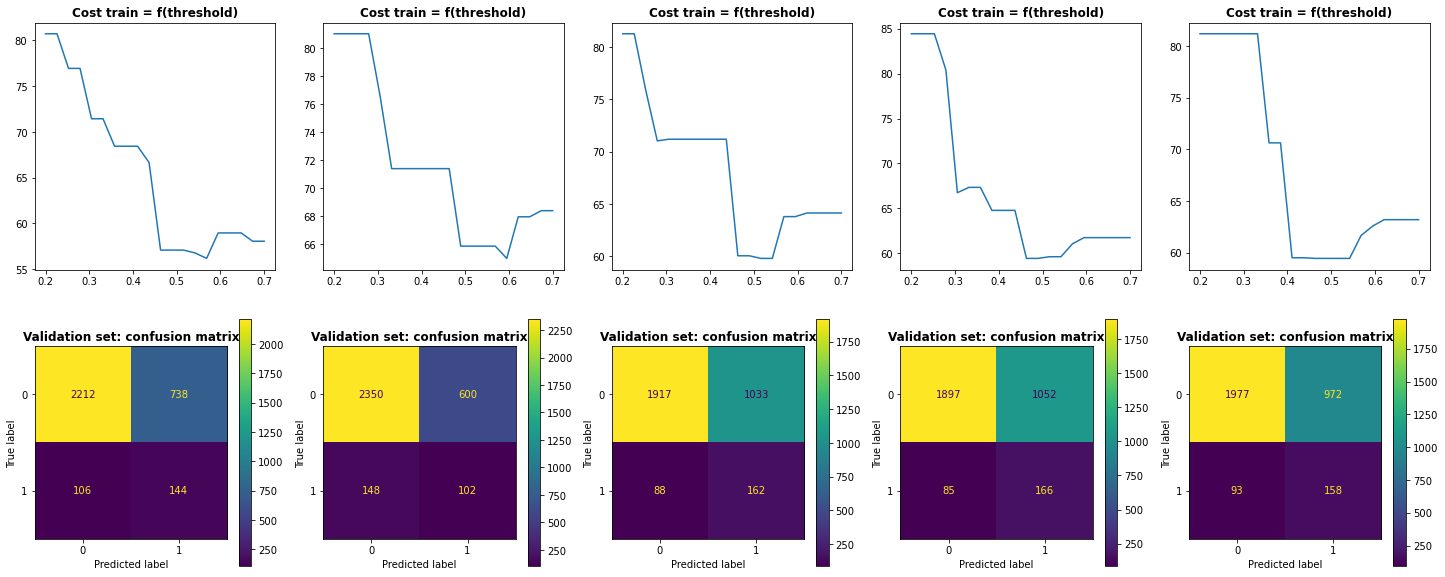

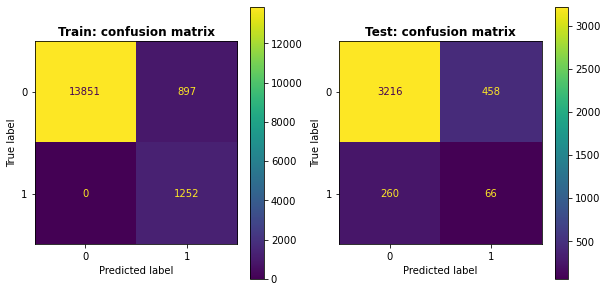

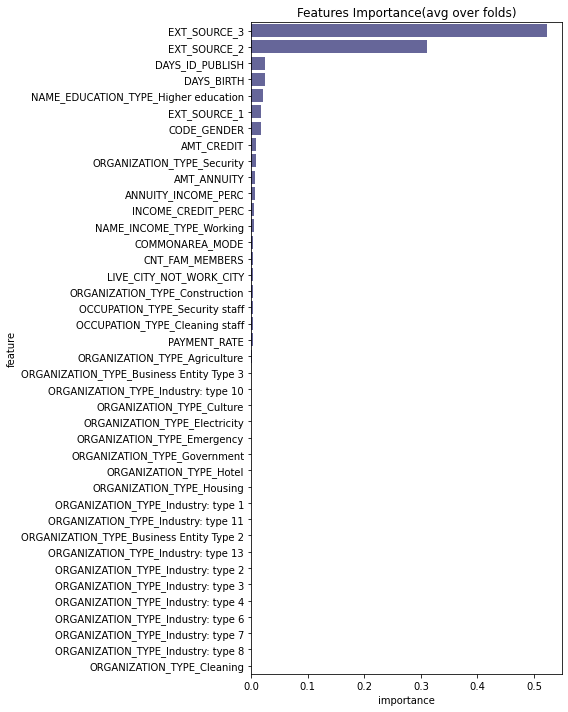

In [808]:
model_decision_tree_balanced(data_transformed_20000)

In [809]:
saved_Decision_Tree_model = joblib.load('Decision_Tree_model.joblib')

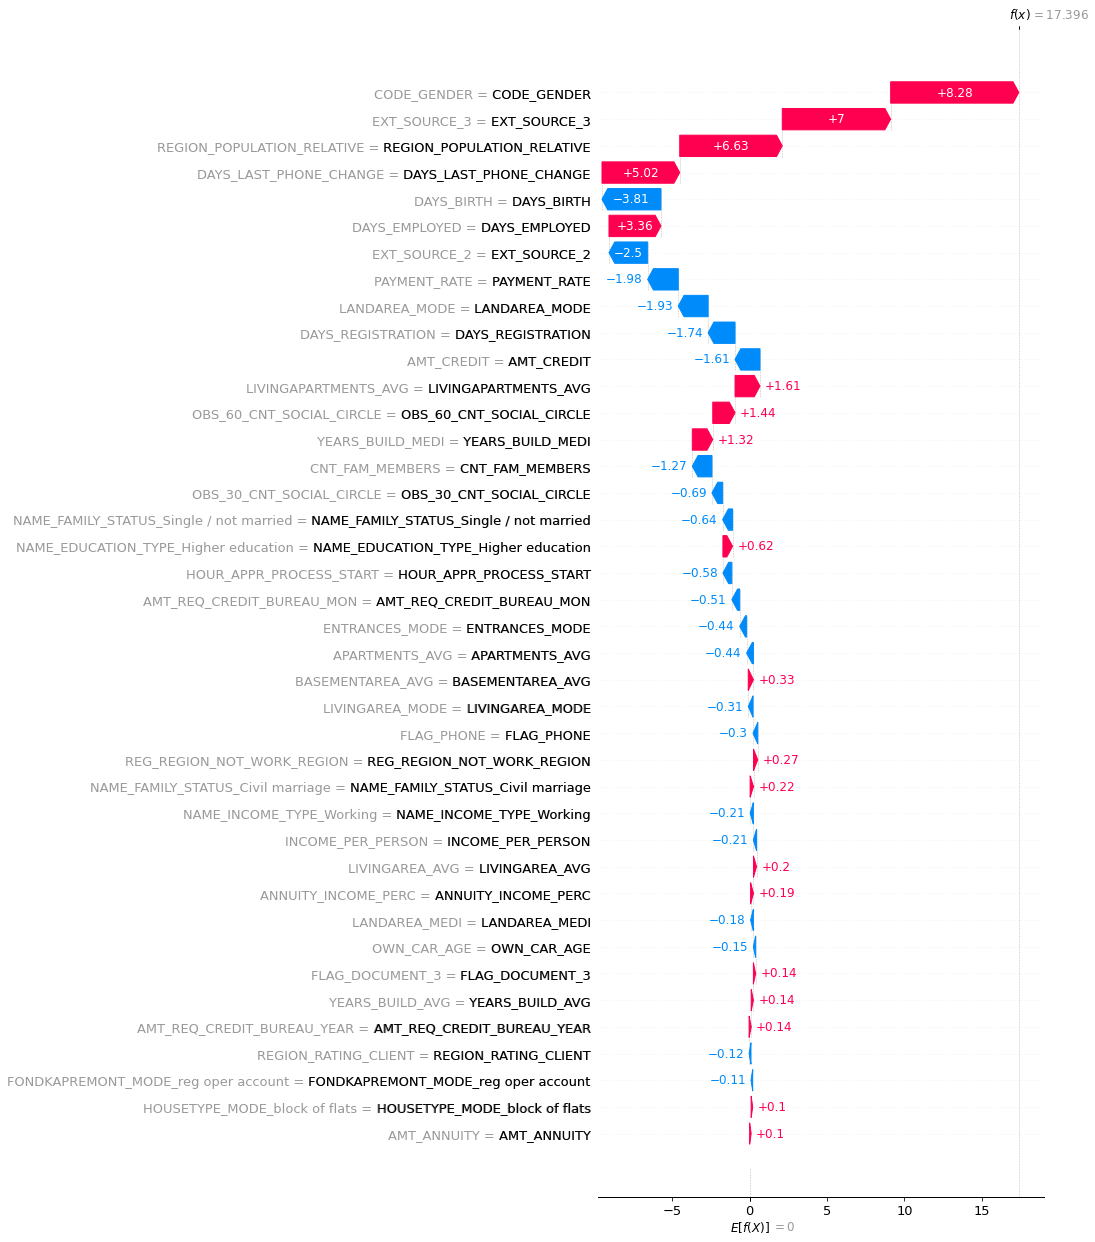

In [810]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.TreeExplainer(saved_Decision_Tree_model['model'], sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Decision_Tree_model['scl'].transform(X_test))
i=1
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Decision tree calibrated

In [811]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Decision_Tree_calibrated(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.feature_importances_
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = DecisionTreeClassifier(criterion='gini', 
                                       splitter='best', 
                                       max_depth=5, 
                                       min_samples_split=2, 
                                       min_samples_leaf=4, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features=None, 
                                       random_state=42, 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       class_weight=None, )
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    
    

In [882]:
def model_decision_tree_calibrated(df, num_folds=10, stratified = True):
    with timer("Run Decision_Tree_calibrated"):
        Decision_Tree_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09921052631578947
           Validation      Train       Test
Accuracy     0.741250   0.785375   0.775500
Cost        57.375000  48.912500  57.550000
F1_score     0.236162   0.290203   0.312404
Precision    0.151659   0.192434   0.215645
Profit      35.125000  43.650000  33.450000
Recall       0.533333   0.589916   0.566667
roc_auc      0.715203   0.767393   0.742373
Run Decision_Tree_calibrated - done in 9s


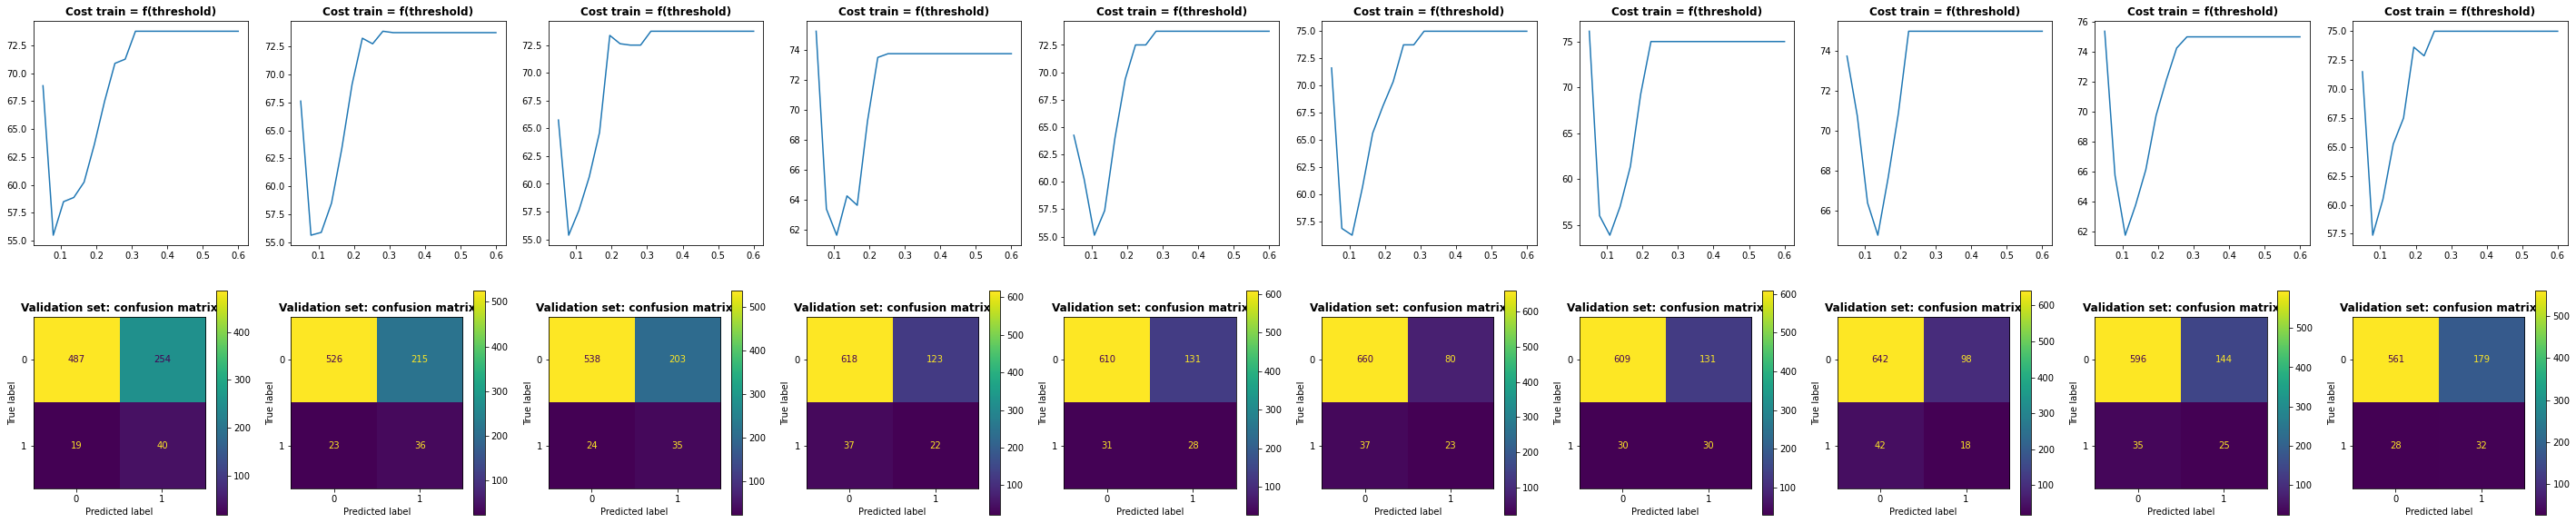

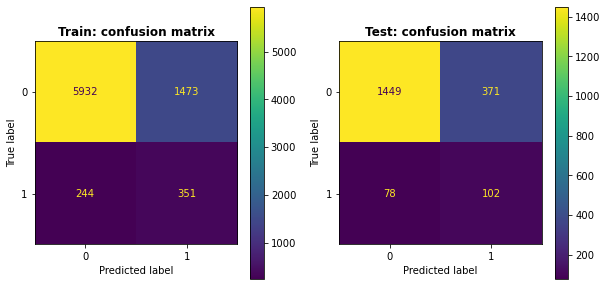

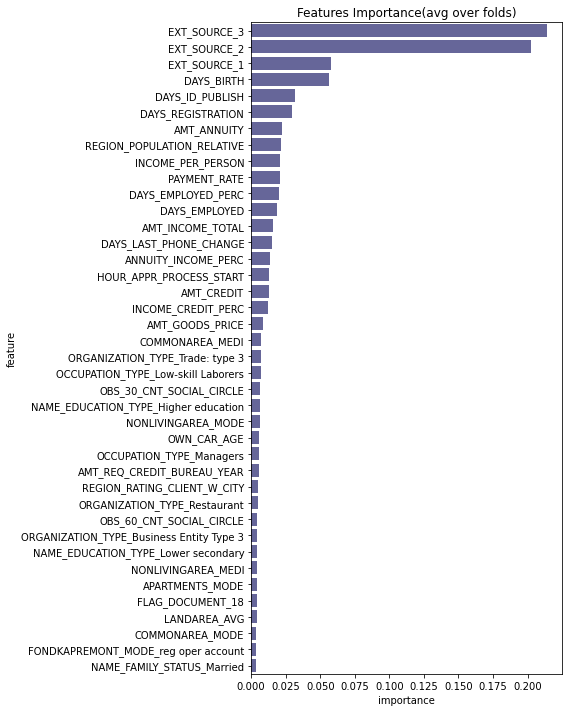

In [883]:
model_decision_tree_calibrated(data_transformed)

In [683]:
saved_Decision_Tree_calibrated = joblib.load('Decision_Tree_calibrated_model.joblib')

In [716]:
saved_Decision_Tree_calibrated['model'].calibrated_classifiers_[0]

# Random forest

## Model

In [814]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier

def Random_Forest(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
        steps = [('scl', scl), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
        
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.02, 0.2, 20)
        cost = []
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = pipe['model'].feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
   
    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    steps = [('scl', scl), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    dump(pipe, 'Random_Forest_model.joblib')
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [884]:
def model5(df, num_folds=10, stratified = True):
    with timer("Run Random_Forest"):
        Random_Forest(df, num_folds, stratified)

Threshold optimum: 0.09578947368421054
Threshold optimum: 0.08631578947368422
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.11473684210526316
Threshold optimum: 0.08631578947368422
Threshold optimum: 0.10526315789473685
Threshold optimum: 0.11473684210526316
Threshold optimum: 0.11473684210526316
Threshold optimum: 0.0768421052631579
Threshold optimum: 0.09578947368421054
Threshold optimum - Mean: 0.09957894736842107
           Validation      Train       Test
Accuracy     0.778750   0.759750   0.750000
Cost        58.125000  48.100000  58.750000
F1_score     0.240343   0.283905   0.295775
Precision    0.161850   0.182384   0.198113
Profit      34.375000  44.462500  32.250000
Recall       0.466667   0.640336   0.583333
roc_auc      0.706486   0.772604   0.737848
Run Random_Forest - done in 9s


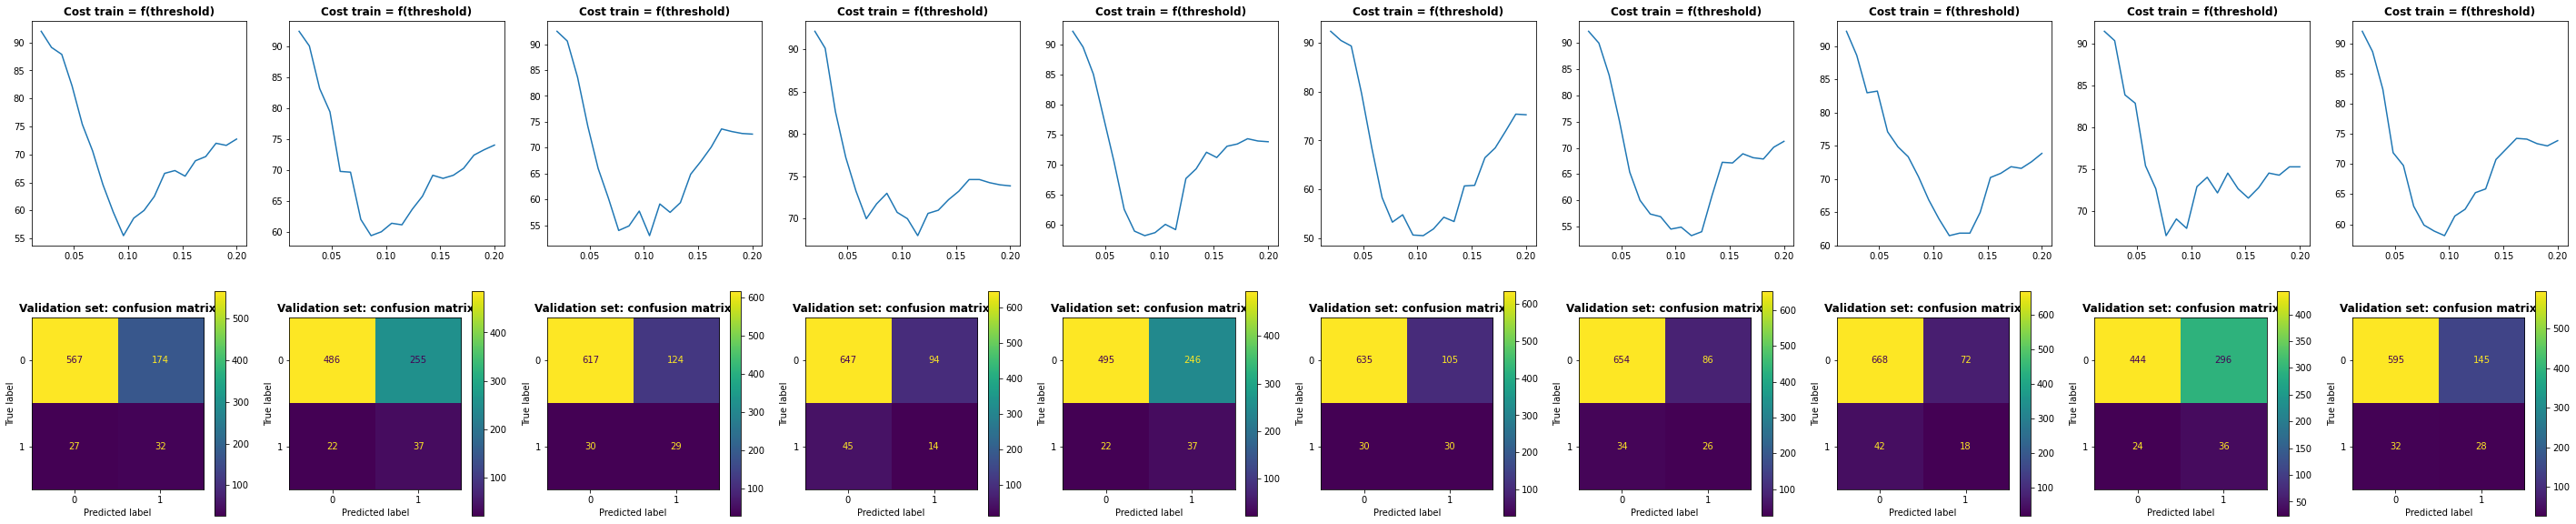

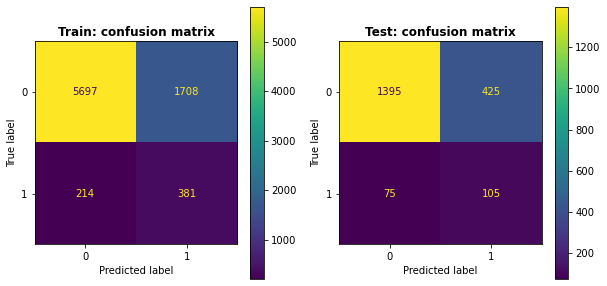

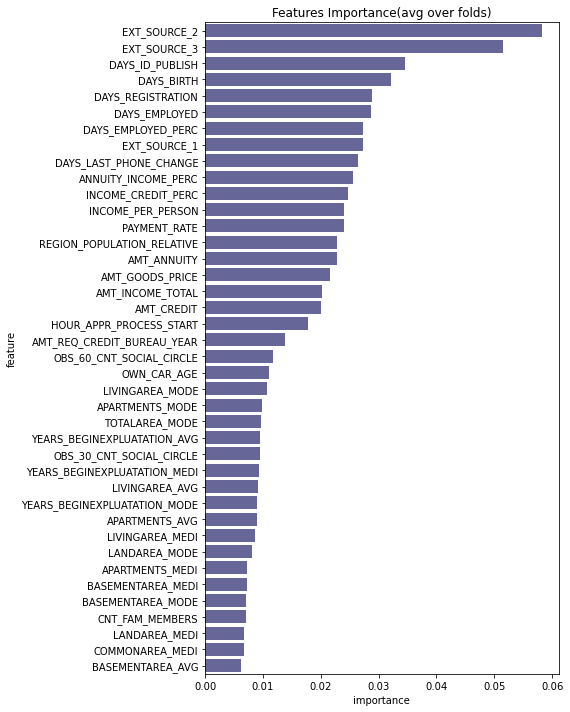

In [885]:
model5(data_transformed)

In [725]:
saved_Random_Forest_model= joblib.load('Random_Forest_model.joblib')

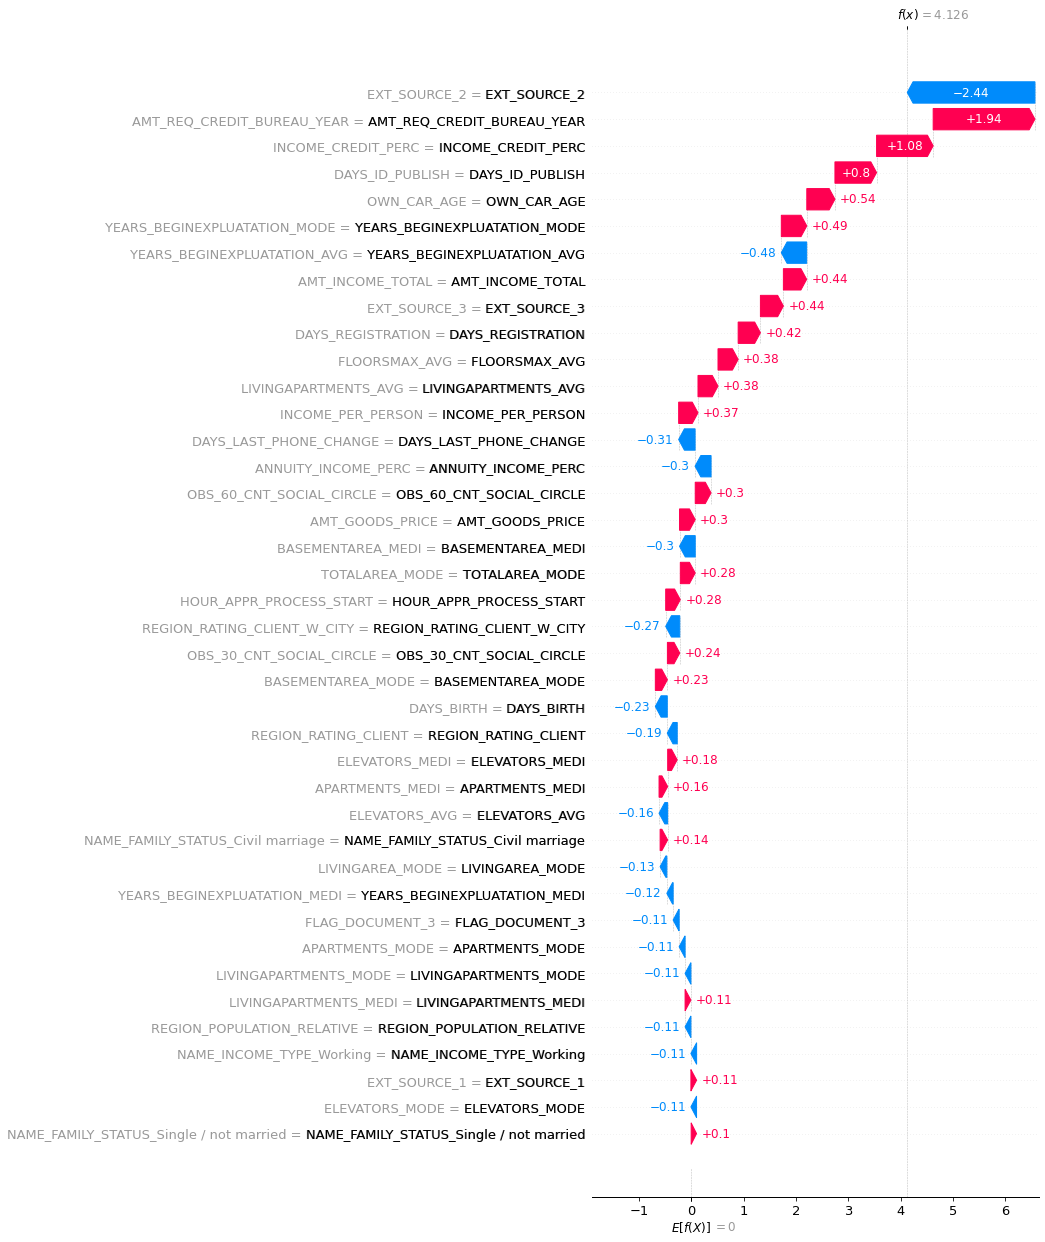

In [730]:
sample = shap.utils.sample(X_train, nsamples=10)
explainer = shap.TreeExplainer(saved_Random_Forest_model['model'], sample)
X_test_transformed = pd.DataFrame(columns=X_train.columns, data=saved_Random_Forest_model['scl'].transform(X_test))
i=100
test_example = X_test_transformed.iloc[i,:]
shap_values = explainer.shap_values(test_example)
features_importantes = pd.DataFrame(index= X_train.columns, columns=['shap'], data=100*shap_values[0])
features_importantes['abs'] = features_importantes['shap'].apply(lambda x: abs(x))
features_importantes = features_importantes.sort_values('abs', ascending=False).iloc[:40]
expected_value =  pd.Series(y_train['TARGET'])[sample.index].mean()

shap.plots.waterfall(WaterfallData(features_importantes, 'shap', expected_value, test_example), max_display=40)
    

## Random_Forest_calibrated

In [817]:
def Random_Forest_calibrated(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
    
        scl = MinMaxScaler()
        regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        fold_importance_df = pd.DataFrame()
        for calibr in pipe['model'].calibrated_classifiers_:
            fold_importance_df_calibr = pd.DataFrame()
            fold_importance_df_calibr["feature"] = features
            fold_importance_df_calibr["importance"] = calibr.base_estimator.feature_importances_
            fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
        fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    regressor = RandomForestClassifier(n_estimators=100,
                                       criterion='gini', 
                                       max_depth=16, 
                                       min_samples_split=5, 
                                       min_samples_leaf=3, 
                                       min_weight_fraction_leaf=0.0, 
                                       max_features='sqrt', 
                                       max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, 
                                       bootstrap=True, 
                                       oob_score=False, 
                                       n_jobs=None, 
                                       random_state=42, 
                                       verbose=0, 
                                       warm_start=False, 
                                       class_weight=None, 
                                       max_samples=299,
                                      ccp_alpha=0.001761)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    
    

In [886]:
def model_Random_Forest_calibrated(df, num_folds=10, stratified = True):
    with timer("Run Random_Forest"):
        Random_Forest_calibrated(df, num_folds, stratified)

Threshold optimum: 0.07894736842105263
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.07894736842105263
Threshold optimum: 0.13684210526315788
Threshold optimum: 0.10789473684210527
Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.09342105263157893
           Validation      Train       Test
Accuracy     0.727500   0.800750   0.785000
Cost        58.750000  47.825000  60.650000
F1_score     0.226950   0.303322   0.301948
Precision    0.144144   0.204962   0.213303
Profit      33.750000  44.737500  30.350000
Recall       0.533333   0.583193   0.516667
roc_auc      0.690991   0.787978   0.730127
Run Random_Forest - done in 16s


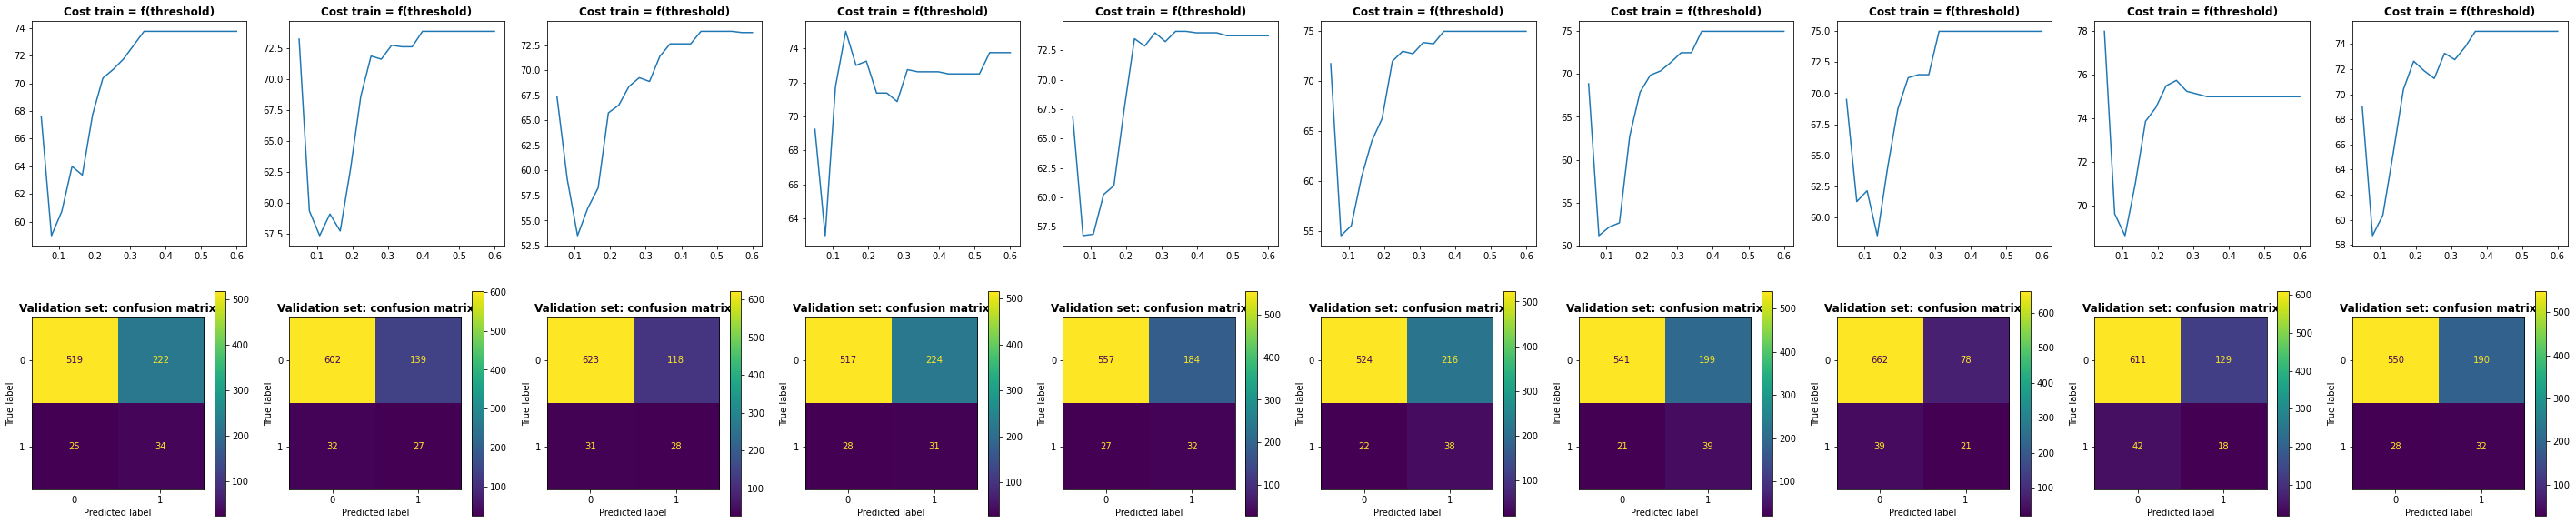

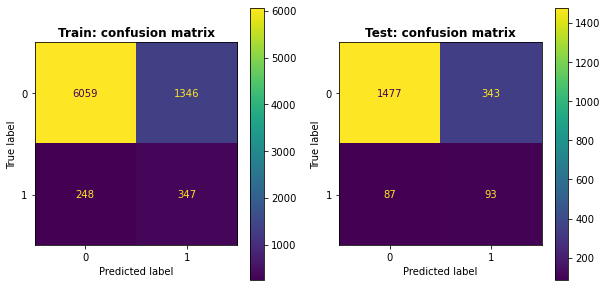

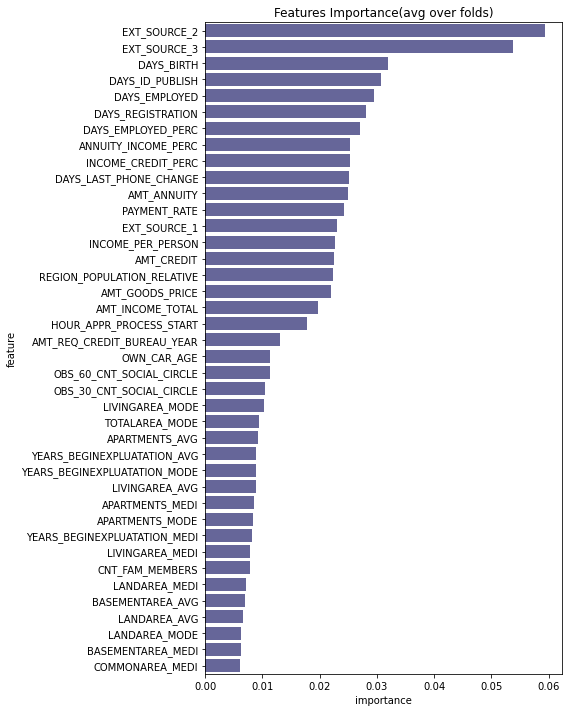

In [887]:
model_Random_Forest_calibrated(data_transformed)

# KNN

In [863]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

def KNN(df, num_folds, stratified = False):
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]

        scl = MinMaxScaler()
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    
        steps = [('scl', scl), ('model', regressor_calibrated)]
        pipe = Pipeline(steps)
    
        pipe.fit(train_x, train_y)
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.05, 0.6, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        

    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")
    
    scl = MinMaxScaler()
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    
    regressor_calibrated = CalibratedClassifierCV(regressor, method='isotonic', cv=3)
    steps = [('scl', scl), ('model', regressor_calibrated)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train)
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    for calibr in pipe['model'].calibrated_classifiers_:
        fold_importance_df_calibr = pd.DataFrame()
        fold_importance_df_calibr["feature"] = features
        fold_importance_df_calibr["importance"] = permutation_importance(pipe, X_train, y_train, scoring='roc_auc').importances_mean
        fold_importance_df = pd.concat([fold_importance_df, fold_importance_df_calibr], axis=0)
    fold_importance_df = fold_importance_df[["feature", "importance"]].groupby("feature").mean().reset_index()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 
    

In [866]:
def model6(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        KNN(df, num_folds, stratified)

Threshold optimum: 0.10789473684210527


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.10789473684210527


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.07894736842105263
Threshold optimum: 0.2526315789473684


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Threshold optimum: 0.07894736842105263
Threshold optimum - Mean: 0.12526315789473683


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


           Validation      Train       Test
Accuracy     0.906250   0.931250   0.940000
Cost        71.250000  68.750000  60.000000
F1_score     0.117647   0.098361   0.000000
Precision    0.200000   1.000000   0.000000
Profit      21.250000  24.000000  34.000000
Recall       0.083333   0.051724   0.000000
roc_auc      0.528153   0.809137   0.685505
Run Logistic regression balanced - done in 913s


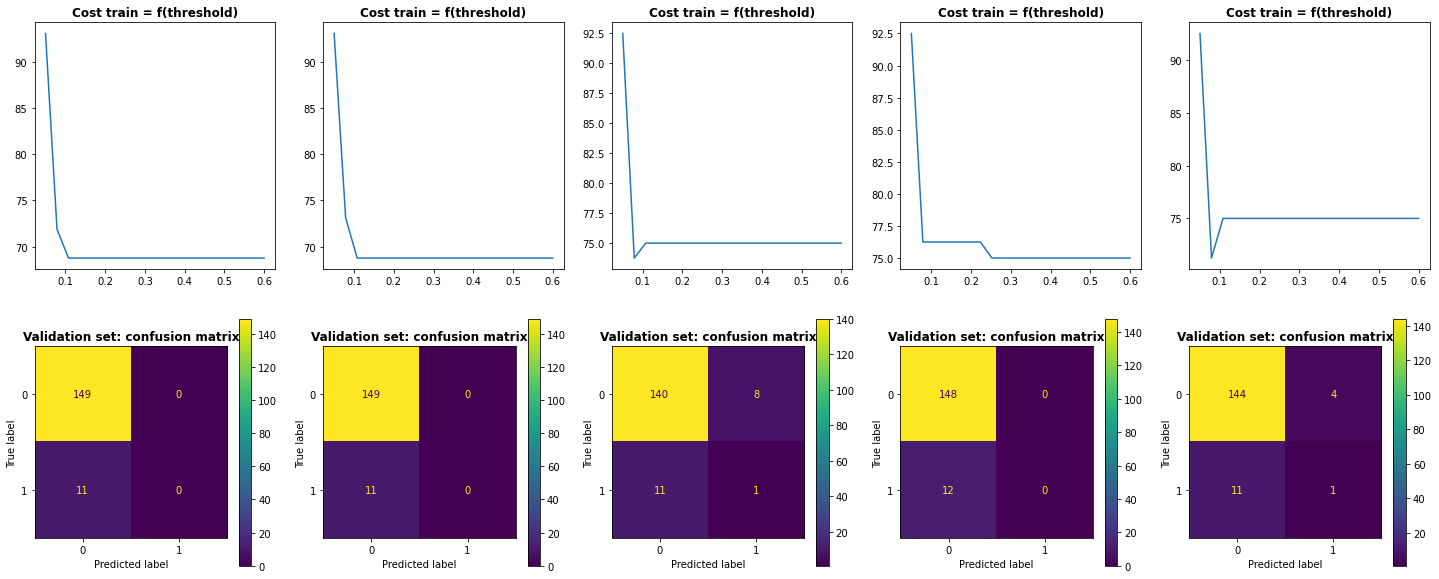

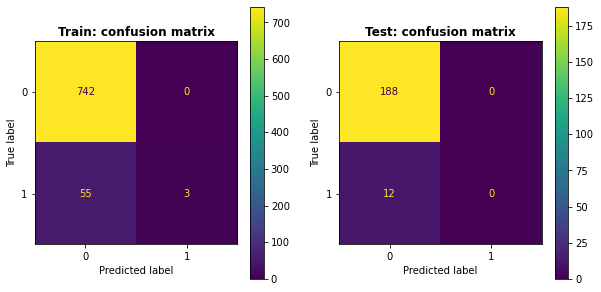

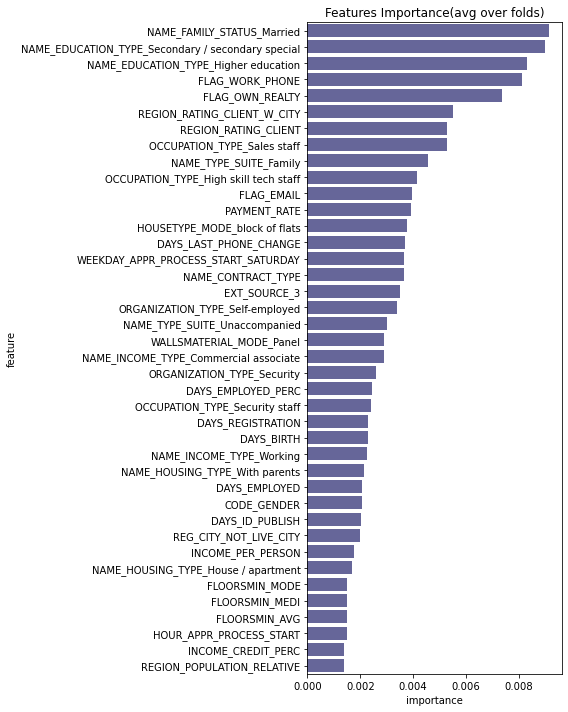

In [868]:
model6(data_transformed_1000)

In [872]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def KNN_smote(df, num_folds, stratified = False):
    
    from imblearn.pipeline import Pipeline
    
    feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    df1 = df[feats]
    # Divide in training and test data
    X = df1[df1['TARGET'].notnull()].drop('TARGET', axis=1)
    y = df1[df1['TARGET'].notnull()]['TARGET']
    
    if stratified:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)    
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
   
    del X, y
    gc.collect()
    
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=42)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
   
    features = [f for f in X_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feature_importance_df = pd.DataFrame()
    result = []
    result_validation_set = pd.DataFrame()
    
    fig, ax = plt.subplots(2, num_folds, figsize=(num_folds*5, 10))
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train[features], y_train)):
        train_x, train_y = X_train[features].iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train[features].iloc[valid_idx], y_train.iloc[valid_idx]
        
        
        scl = MinMaxScaler()
        over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
        under = RandomUnderSampler(random_state=42, sampling_strategy=0.9)
        regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
        steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
        pipe = Pipeline(steps)
        pipe.fit(train_x, train_y)
    
    
    # Calcul des scores roc_auc pour valid et test
        valid_predict = pipe.predict_proba(valid_x)
        valid_predict_proba = [pred[1] for pred in valid_predict]
        valid_predict_proba_df = pd.DataFrame(valid_predict_proba)
        
        param = np.linspace(0.4, 0.7, 20)
        cost = []
        
        for i in param: 
            valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>i else 0)
            cm_valid = confusion_matrix(valid_y, valid_predict_class)
            cost += [(10*cm_valid[1][0] + cm_valid[0][1])/len(valid_y)*100]
        sns.lineplot(ax=ax[0][n_fold], x=param, y=cost)
        ax[0][n_fold].set_title('Cost train = f(threshold)', weight='bold')
    
        # Construction des matrices de confusion avec le meilleur threshold
        best_param = param[cost.index(min(cost))]
        print(f"Threshold optimum: {best_param}")
        result += [best_param]
        valid_predict_class = valid_predict_proba_df.applymap(lambda x: 1 if x>best_param else 0)
        cm_valid = confusion_matrix(valid_y, valid_predict_class)
        confusion_valid = ConfusionMatrixDisplay(cm_valid)
        confusion_valid.plot(ax=ax[1][n_fold])
        confusion_valid.ax_.set_title('Validation set: confusion matrix', weight='bold')
        
        
        
        results_valid = [accuracy_score(valid_y, valid_predict_class),
                    (10*cm_valid[1][0] + cm_valid[0][1])/len(valid_x)*100,
                    f1_score(valid_y, valid_predict_class),
                    precision_score(valid_y, valid_predict_class),
                    (cm_valid[0][0]-(10*cm_valid[1][0] ))/len(valid_x)*100,
                    recall_score(valid_y, valid_predict_class),
                    roc_auc_score(valid_y, valid_predict_proba)] 
        result_validation_set['n_fold'] = results_valid
    result_validation = list(result_validation_set.mean(axis=1))
        
    best_threshold = np.array(result).mean()
    print(f"Threshold optimum - Mean: {best_threshold}")

    scl = MinMaxScaler()
    over = SMOTE(random_state=42, sampling_strategy=0.4, k_neighbors=3)
    under = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
    regressor = KNeighborsClassifier(weights='uniform', 
                                     algorithm='auto',  
                                     p=2, 
                                     metric='minkowski',
                                     leaf_size=30,
                                     metric_params=None, 
                                     n_jobs=None)
    steps = [('scl', scl), ('over', over), ('under', under), ('model', regressor)]
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    
    train_predict = pipe.predict_proba(X_train)
    train_predict_proba = [pred[1] for pred in train_predict]
    train_predict_proba_df = pd.DataFrame(train_predict_proba)
    train_predict_class = train_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    test_predict = pipe.predict_proba(X_test)
    test_predict_proba = [pred[1] for pred in test_predict]
    test_predict_proba_df = pd.DataFrame(test_predict_proba)
    test_predict_class = test_predict_proba_df.applymap(lambda x: 1 if x>best_threshold else 0)
    
    cm_train = confusion_matrix(y_train, train_predict_class)
    confusion_train = ConfusionMatrixDisplay(cm_train)
    cm_test = confusion_matrix(y_test, test_predict_class)
    confusion_test = ConfusionMatrixDisplay(cm_test)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = permutation_importance(pipe, train_x, train_y, scoring='roc_auc').importances_mean
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    feature_importance_df["importance"] = feature_importance_df["importance"].apply(lambda x: abs(x))
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    confusion_train.plot(ax=ax[0])
    confusion_train.ax_.set_title('Train: confusion matrix', weight='bold')
    confusion_test.plot(ax=ax[1])
    confusion_test.ax_.set_title('Test: confusion matrix', weight='bold')
    
    results_test = [accuracy_score(y_test, test_predict_class),
                    (10*cm_test[1][0] + cm_test[0][1])/len(X_test)*100,
                    f1_score(y_test, test_predict_class),
                    precision_score(y_test, test_predict_class),
                    (cm_test[0][0]-(10*cm_test[1][0] ))/len(X_test)*100,
                    recall_score(y_test, test_predict_class),
                    roc_auc_score(y_test, test_predict_proba)] 
    results_train = [accuracy_score(y_train, train_predict_class),
                    (10*cm_train[1][0] + cm_train[0][1])/len(X_train)*100,
                    f1_score(y_train, train_predict_class),
                    precision_score(y_train, train_predict_class),
                    (cm_train[0][0]-(10*cm_train[1][0] ))/len(X_train)*100,
                    recall_score(y_train, train_predict_class),
                    roc_auc_score(y_train, train_predict_proba)] 
    print(score_df(results_train, result_validation, results_test))
   
    display_importances(feature_importance_df) 

In [873]:
def model6_bis(df, num_folds=5, stratified = True):
    with timer("Run Logistic regression balanced"):
        KNN_smote(df, num_folds, stratified)

Threshold optimum: 0.6052631578947368
Threshold optimum: 0.6052631578947368
Threshold optimum: 0.4
Threshold optimum: 0.4
Threshold optimum: 0.6052631578947368
Threshold optimum - Mean: 0.523157894736842
           Validation      Train       Test
Accuracy     0.593750   0.560000   0.445000
Cost        57.500000  44.000000  73.500000
F1_score     0.216867   0.247863   0.125984
Precision    0.126761   0.141463   0.069565
Profit      35.000000  48.750000  20.500000
Recall       0.750000   1.000000   0.666667
roc_auc      0.625282   0.960080   0.637190
Run Logistic regression balanced - done in 28s


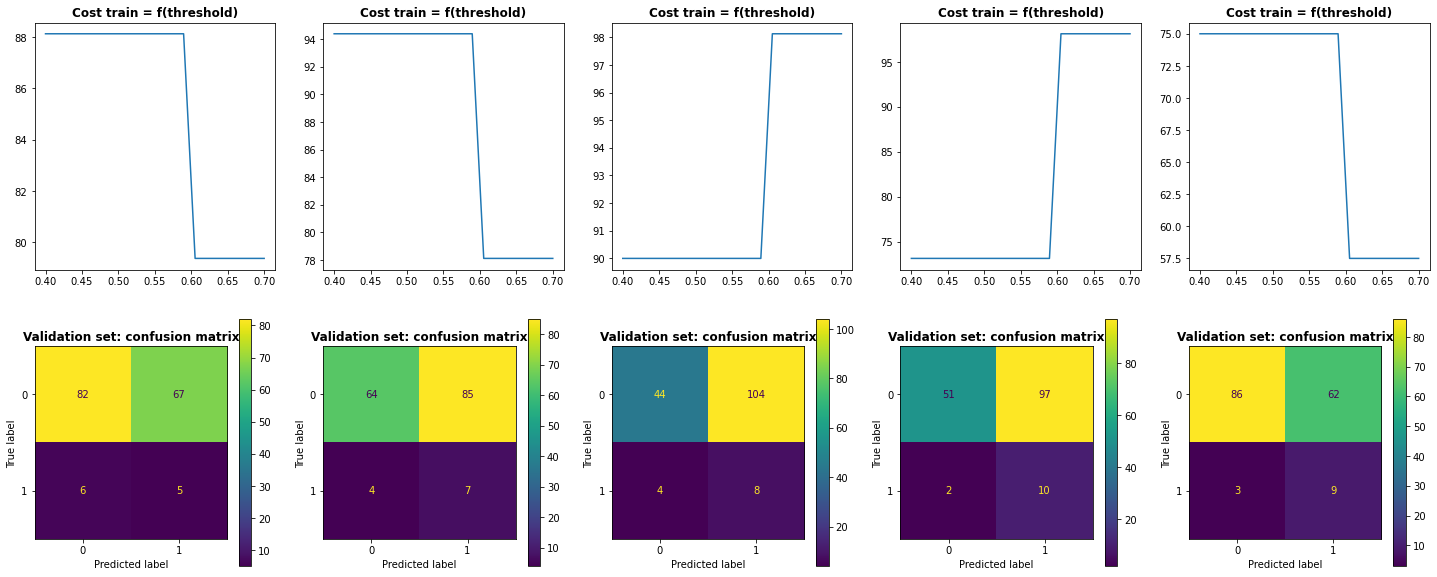

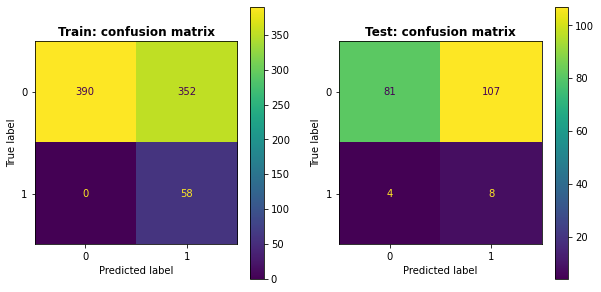

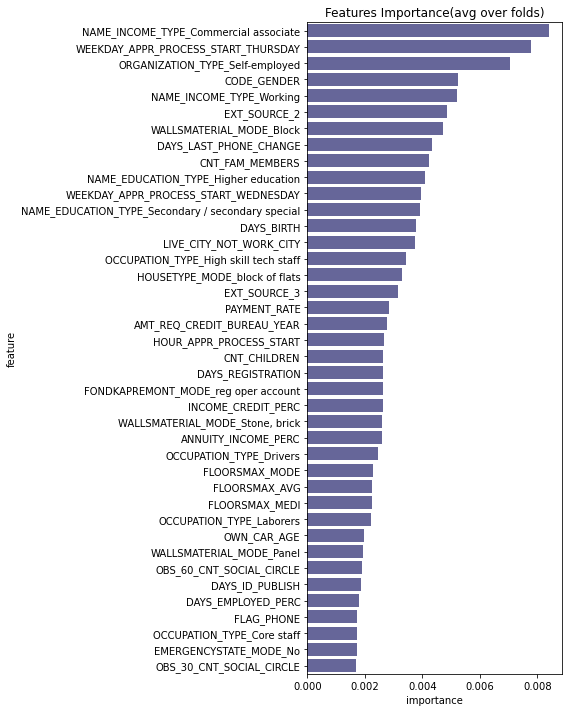

In [874]:
model6_bis(data_transformed_1000)

# Fin

In [839]:
X_train

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                      0            1             0                0   
1                      1            1             0                0   
2                      0            1             1                1   
3                      0            1             0                0   
4                      0            1             0                0   
...                  ...          ...           ...              ...   
7995                   0            0             1                0   
7996                   0            1             0                0   
7997                   0            1             0                1   
7998                   0            1             0                1   
7999                   0            1             1                0   

      CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1          157500.0    485640.0      38263.5   
1                0          315000.0    382500.0      19125.0   
2                1          315000.0    700830.0      18486.0   
3                0           45000.0    254700.0      14751.0   
4                0          225000.0    463500.0      15079.5   
...            ...               ...         ...          ...   
7995             2          211500.0    277969.5      16087.5   
7996             0          247500.0    225000.0      22050.0   
7997             0           67500.0    276277.5      14593.5   
7998             0           87750.0    454500.0      14661.0   
7999             0          180000.0    273636.0      15835.5   

      AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            450000.0                    0.010006      -12956         -151.0   
1            382500.0                    0.019101      -16292        -5504.0   
2            585000.0                    0.002506      -19015        -3497.0   
3            225000.0                    0.009175      -23815        -1699.0   
4            463500.0                    0.030755      -18018        -3838.0   
...               ...                         ...         ...            ...   
7995         229500.0                    0.030755      -13673        -2079.0   
7996         225000.0                    0.032561      -23438        -2633.0   
7997         238500.0                    0.018029      -10487         -721.0   
7998         454500.0                    0.018850      -14441        -2286.0   
7999         247500.0                    0.022800      -18974        -2158.0   

      DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0                -787.0            -4181          9.0           1   
1                -416.0            -2325          9.0           1   
2              -10981.0            -2280         14.0           1   
3                -188.0            -4386          9.0           1   
4               -7476.0            -1500          9.0           1   
...                 ...              ...          ...         ...   
7995             -418.0            -4501          1.0           1   
7996           -11084.0            -4047          9.0           1   
7997             -214.0             -647          9.0           1   
7998              -89.0            -1042          9.0           1   
7999            -7409.0            -2473          2.0           1   

      FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                  1                0                 1           0   
1                  1                0                 1           1   
2                  1                1                 1           1   
3                  0                0                 1           0   
4                  1                0                 1           0   
...              ...              ...               ...         ...   
7995               1                0                 1           0   
79